In [1]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests
import plotly.express as px
from zipfile import ZipFile
import json
import random
import os, urllib
import seaborn  as sbn

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress
from geopy_pelias import Pelias
from geopy_bepelias import BePelias


from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         arcgis_username, arcgis_password,
                         best_client_id, best_client_secret, best_hostname)



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

In [2]:
# dataset = "rrn_1000"
# dataset = "kbo_1000"
# dataset = "best_1000"
# dataset = "best2_1000"
dataset = "rep_1000"
# dataset = "resto_1000"

# dataset = "kbo_10000"
# dataset = "rrn_10000"
# dataset = "rep_10000"
# dataset = "best_10000"

In [3]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [4]:
def_figsize = (10,8)

In [5]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [6]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
#         ctx.add_basemap(ax, zoom=zoom)
#     except requests.HTTPError:
#         print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    except ValueError as e:
        print("Value error...")
        print(e)
    except NameError as e:
        print("contextily not installed")

In [7]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [8]:
def pdf_savefig():
    try: 
        pdf.savefig(bbox_inches='tight')
    except AttributeError:
        print("PDF probably closed")

In [9]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [10]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_loc": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_loc": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon": {
            "house": "building",
            "locality": "city",
            "district": "city",
            "city": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if "pelias" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        
        raw_label = record.location.raw["properties"]
        
        if (raw_label["match_type"] in ["exact", "interpolated"] or raw_label["accuracy"]=="point") and 'housenumber' in raw_label:
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
    
    if "jcd" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        return "building"
        
    if "arcgis" in record.geocoder:
        attr = record.location.raw["attributes"]
        if "AddNum" in attr and len(attr["AddNum"])>0:
            return "building"
        if "StName" in attr and len(attr["StName"])>0:
            return "street"
        if "City" in attr and len(attr["City"])>0:
            return "city"
        
        return "[UNKNOWN]"
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        if record.geocoder == "mapbox":
            return "city"
        return "[UNKNOWN]"
    
    

In [11]:
# geocoded_data.loc[6999].location.raw

In [12]:
# geocoders['arcgis'].geocode("saint-illes, belgique").raw
# get_precision(geocoded_data.loc[6999])

In [13]:
geocoders = {}

In [14]:
from geopy.geocoders import Nominatim
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
# geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [15]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [16]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [17]:
# from geopy.geocoders import Pelias
geocoders['pelias']              = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4005", scheme="http", timeout=1000)
geocoders['pelias_struct']       = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4005", scheme="http", timeout=1000)
geocoders['pelias_struct_noloc'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4005", scheme="http", timeout=1000, with_localities=False)


In [18]:
# geocoders['pelias'].geocode("Rue de Namur 23, 5190 Spy")

In [698]:
# geocoders['pelias_struct'].verbose=True
# geocoders['pelias_struct'].geocode({"street": "Avenue Fonsny", "housenumber": "20", "postcode": "1060", "city": "Saint-Gilles"})
# geocoders['pelias_struct'].geocode({"street": "Rue des Vierges", "housenumber": "25", "postcode": "9600", "city": "Renaix"})

# geocoders['pelias_struct'].geocode({""		Renaix


In [699]:
# geocoders['pelias_struct'].with_localities

In [700]:
# from geopy.geocoders import Pelias
# For peliase installed through bePelias procedure
geocoders['be_pelias_basic_unstruct']        = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)
geocoders['be_pelias_basic_struct'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)
geocoders['be_pelias_basic_struct_noloc'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000, with_localities=False)


In [701]:
# geocoders['be_pelias'].geocode({"street": "Rue des Vierges", "housenumber": "25", "postcode": "9600", "city": "renaix"}).raw

In [702]:
geocoders['be_pelias_basic'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="basic")


In [703]:
geocoders['be_pelias_simple'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
                                    mode="simple")


In [704]:
geocoders['be_pelias'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="advanced")


In [705]:
# geocoders['be_pelias_basic_struct'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
# #                                     mode="simple")
#                                     mode="struct")

# geocoders['be_pelias_basic_struct_noloc'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
# #                                     mode="simple")
#                                     mode="struct_noloc")

# geocoders['be_pelias_basic_unstruct'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
# #                                     mode="simple")
#                                     mode="unstruct")


In [706]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [707]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [708]:
from geopy.geocoders import Photon
# geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon'] = Photon(domain="127.0.0.1:2322", scheme="http")

# geocoders['photon'].geocode("Avenue Fonsny 20, 1060 Bruxelles").raw

In [709]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [710]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [711]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [712]:
from geopy.geocoders import ArcGIS
arcgis = ArcGIS(username=arcgis_username, password=arcgis_password, referer="www.smalsresearch.Be")
arcgis._geocode = arcgis.geocode
arcgis.geocode = lambda x: arcgis._geocode(x, out_fields="*")
geocoders["arcgis"] = arcgis

In [713]:
from matplotlib.backends.backend_pdf import PdfPages


In [714]:
geocoders['arcgis'].geocode("1060 bxl, belgique").raw

{'address': '1060, Sint-Gillis, Brussel Hoofdstedelijk Gewest',
 'location': {'x': 4.3451859, 'y': 50.8251293},
 'score': 91.08,
 'attributes': {'Loc_name': 'World',
  'Status': 'M',
  'Score': 91.08,
  'Match_addr': '1060, Sint-Gillis, Brussel Hoofdstedelijk Gewest',
  'LongLabel': '1060, Sint-Gillis, Brussel Hoofdstedelijk Gewest, BEL',
  'ShortLabel': '1060',
  'Addr_type': 'Postal',
  'Type': '',
  'PlaceName': '1060',
  'Place_addr': '1060, Sint-Gillis',
  'Phone': '',
  'URL': '',
  'Rank': 5,
  'AddBldg': '',
  'AddNum': '',
  'AddNumFrom': '',
  'AddNumTo': '',
  'AddRange': '',
  'Side': '',
  'StPreDir': '',
  'StPreType': '',
  'StName': '',
  'StType': '',
  'StDir': '',
  'BldgType': '',
  'BldgName': '',
  'LevelType': '',
  'LevelName': '',
  'UnitType': '',
  'UnitName': '',
  'SubAddr': '',
  'StAddr': '',
  'Block': '',
  'Sector': '',
  'Nbrhd': '',
  'District': '',
  'City': 'Sint-Gillis',
  'MetroArea': '',
  'Subregion': 'Brussel',
  'Region': 'Brussel Hoofdstede

In [715]:
# geocoders['be_pelias_basic_unstruct'].geocode("Rue de Namur, 5190 Spy").raw

In [716]:
# geocoders['google'].geocode("Dorpstraat, Geldrode").raw

# Load data


In [717]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [718]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3            Rue du Hock(N), 36, 4121 Neupré, Belgique  
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
..                                                 ...  
995            Lichterweg, 3, 2030 Antwerpen, Belgique  
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique  
997             Heerweg-Noord, 72, 9052 Gent, Belgique  
998              Mechelbaan, 750, 2580 Putte, Belgique  
999           Dikkebusseweg, 126, 8900 Ieper, Belgique  

[1000 rows x 5 columns]

In [719]:
data = data.reset_index().rename(columns={"index": "reference_key"})

In [720]:
# data

In [721]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

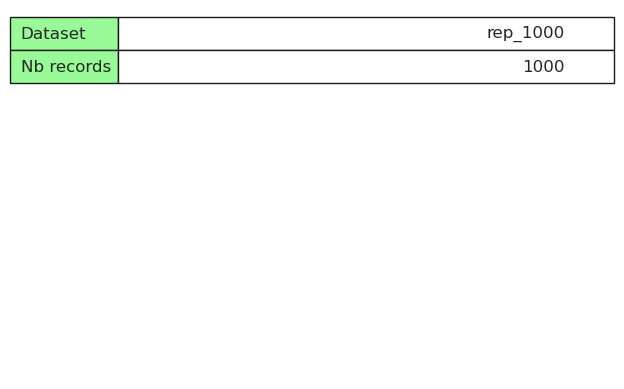

In [722]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf_savefig()

# Geocode

In [723]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [724]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr,
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [725]:
geocoded_data_r = [] #gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim", "here", "bing", "mapbox", "tomtom", "google", "bestaddress", 
        "ngi_pelias"]
coders=["nominatim_wrapper", "nominatim", "here", "bing", "google", "tomtom", "ngi_pelias"]

coders=["nominatim", "be_pelias", "here", "bing", "google", "tomtom"]

coders=["here", "bing", "google", "nominatim", "nominatim_wrapper", "be_pelias", "arcgis"]

# coders=["pelias_struct_noloc", "pelias_struct", "pelias"]

# coders=["be_pelias_basic_struct_noloc", "be_pelias_basic_struct", "be_pelias_basic_unstruct"]

# coders=["be_pelias"]

# coders=["be_pelias", "pelias_struct_noloc", "pelias_struct", "pelias"]

#coders=["be_pelias_basic_struct_noloc", "be_pelias_basic_struct", "be_pelias_basic_unstruct", "pelias_struct_noloc", "pelias_struct", "pelias"]

# coders=[ "bing", "google", "here", "tomtom", "nominatim", "nominatim_wrapper", "pelias", "ngi_pelias", "jcd"]
# coders=[ "bing", "google", "here", "tomtom", "nominatim", "pelias", "photon"]

# coders = ["here", "bing", "tomtom", "google", "nominatim_wrapper", "nominatim"]
# coders = ["here", "bing", "tomtom", "google", "nominatim_loc"]

# coders = ["nominatim"]
# from_file = coders
# from_file = [] 

# coders =["pelias", "pelias_struct", "ngi_pelias_basic", "ngi_pelias_simple", "ngi_pelias"]
# from_file=["pelias", "pelias_struct", ] 
# from_file = coders

from_file = coders

# coders = ["be_pelias"]
# from_file=[] 



delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim":0.01, "lpost_bestaddress": 0.01, "google":0.05, "tomtom": 0.4, 
       "bing": 0.05, "arcgis": 0.05}
for c in coders:
    if "pelias" in c:
        delay[c] = 0.02


for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder in ["bestaddress", "be_pelias", 'be_pelias_basic', 'be_pelias_simple', "pelias_struct", "pelias_struct_noloc",
                    "be_pelias_basic_struct", "be_pelias_basic_struct_noloc"]: # structured addresses
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)

        else: 
            g_data = data.assign(location=(data['address'].str.replace("/", "%2F") if coder=="tomtom" else data['address']).progress_apply(geocode)).assign(geocoder=coder)
#             g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)

here
Load from local file...


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  reference_key  
0    (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...     here              0  
1    (Nachtegalenlaan 35, 1950 Kraainem, België, Kr...     here              1  
2    (Rue Tilia 12, 6511 Beaumont, Belgique, Beaumo...     here              2  
3    (Rue du Hock 36, 4121 Neupré, Belgique, Neupré...     here              3  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, België, ...     here              4  
..                                                 ...      ...            ...  
995  (Lichterweg, 2030 Antwerpen, België, Antwerpen...     here            995  
996  (Grote Markt 41, 8500 Kortrijk, België, Kortri...     here            996  
997  (Heerweg-Noord 72, 9052 Gent, België, Gent, Vl...     here            997  
998  (Mechelbaan 750, 2580 Putte, België, Putte, Vl...     here            998  
999  (Dikkebusseweg 126, 8900 Ieper, België, Ieper,...     here            999  

[1000 rows x 8 columns]

bing
Load from local file...


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  reference_key  
0    (Avenue de Burbure 46, Wezembeek-Oppem, Flemis...     bing              0  
1    (Avenue des Rossignols 35, Kraainem, Flemish R...     bing              1  
2    (Rue Tilia 12, Beaumont, Walloon Region 6511, ...     bing              2  
3    (Rue du Hock 36, Neuville-en-Condroz, Walloon ...     bing              3  
4    (Wuustwezelseweg 95, Wuustwezel, Flemish Regio...     bing              4  
..                                                 ...      ...            ...  
995  (Lichterweg, Antwerp, Flemish Region 2000, Bel...     bing            995  
996  (Grote Markt 41, Kortrijk, Flemish Region 8500...     bing            996  
997  (Heerweg-Noord 72, Ghent, Flemish Region 9052,...     bing            997  
998  (Mechelbaan 750, Putte, Flemish Region 2580, B...     bing            998  
999  (Dikkebusseweg 126, leper, Flemish Region 8900...     bing            999  

[1000 rows x 8 columns]

google
Load from local file...


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  reference_key  
0    (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...   google              0  
1    (Nachtegalenlaan 35, 1950 Kraainem, Belgium, (...   google              1  
2    (Rue Tilia 12, 6511 Beaumont, Belgium, (50.273...   google              2  
3    (Rue du Hock 36, 4121 Neupré, Belgium, (50.553...   google              3  
4    (Wuustwezelseweg 95, 2990 Wuustwezel, Belgium,...   google              4  
..                                                 ...      ...            ...  
995  (Lichterweg 3, 2030 Antwerpen, Belgium, (51.24...   google            995  
996  (Grote Markt, 8500 Kortrijk, Belgium, (50.8276...   google            996  
997  (Heerweg-Noord 72, 9052 Gent, Belgium, (51.005...   google            997  
998  (Mechelbaan 750, 2580 Putte, Belgium, (51.0382...   google            998  
999  (Dikkebusseweg 126, 8900 Ieper, Belgium, (50.8...   google            999  

[1000 rows x 8 columns]

nominatim
Load from local file...


reference_key            street housenumber postcode             city  \
0                0    de Burburelaan          46     1970  Wezembeek-Oppem   
1                1   Nachtegalenlaan          35     1950         Kraainem   
2                2     Rue Tilia(ST)          12     6511         Beaumont   
3                3    Rue du Hock(N)          36     4121           Neupré   
4                4   Wuustwezelseweg          95     2990       Wuustwezel   
..             ...               ...         ...      ...              ...   
995            995        Lichterweg           3     2030        Antwerpen   
996            996  Grote Markt(Kor)          41     8500         Kortrijk   
997            997     Heerweg-Noord          72     9052             Gent   
998            998        Mechelbaan         750     2580            Putte   
999            999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location   geocoder  
0    (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim  
1    (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim  
2    (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim  
3    (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim  
4    (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim  
..                                                 ...        ...  
995  (Lichterweg, Antwerpen, Vlaanderen, 2030, Belg...  nominatim  
996                                               None  nominatim  
997  (Heerweg-Noord, Zwijnaarde, Gent, Oost-Vlaande...  nominatim  
998  (Mechelbaan, Putte, Mechelen, Antwerpen, Vlaan...  nominatim  
999  (Dikkebusseweg, Ieper, West-Vlaanderen, Vlaand...  nominatim  

[1000 rows x 8 columns]

nominatim_wrapper
Load from local file...


street housenumber postcode             city  \
0      de Burburelaan          46     1970  Wezembeek-Oppem   
1     Nachtegalenlaan          35     1950         Kraainem   
2       Rue Tilia(ST)          12     6511         Beaumont   
3      Rue du Hock(N)          36     4121           Neupré   
4     Wuustwezelseweg          95     2990       Wuustwezel   
..                ...         ...      ...              ...   
995        Lichterweg           3     2030        Antwerpen   
996  Grote Markt(Kor)          41     8500         Kortrijk   
997     Heerweg-Noord          72     9052             Gent   
998        Mechelbaan         750     2580            Putte   
999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location           geocoder  \
0    (Oscar de Burburelaan, Wezembeek, Wezembeek-Op...  nominatim_wrapper   
1    (35, Nachtegalenlaan, Kraainem, Halle-Vilvoord...  nominatim_wrapper   
2    (Rue Tilia, Strée, Beaumont, Thuin, Hainaut, W...  nominatim_wrapper   
3    (36, Rue du Hock, Neuville-en-Condroz, Neupré,...  nominatim_wrapper   
4    (95, Wuustwezelseweg, Loenhout, Wuustwezel, An...  nominatim_wrapper   
..                                                 ...                ...   
995  (Lichterweg, Antwerpen, Vlaanderen, 2030, Belg...  nominatim_wrapper   
996  (41, Grote Markt, Begijnhof Sint-Elisabeth, Ko...  nominatim_wrapper   
997  (Heerweg-Noord, Zwijnaarde, Gent, Oost-Vlaande...  nominatim_wrapper   
998  (Mechelbaan, Putte, Mechelen, Antwerpen, Vlaan...  nominatim_wrapper   
999  (Dikkebusseweg, Ieper, West-Vlaanderen, Vlaand...  nominatim_wrapper   

     reference_key  
0                0  
1                1  
2                2  
3                3  
4                4  
..             ...  
995            995  
996            996  
997            997  
998            998  
999            999  

[1000 rows x 8 columns]

be_pelias
Load from local file...


reference_key            street housenumber postcode             city  \
0                0    de Burburelaan          46     1970  Wezembeek-Oppem   
1                1   Nachtegalenlaan          35     1950         Kraainem   
2                2     Rue Tilia(ST)          12     6511         Beaumont   
3                3    Rue du Hock(N)          36     4121           Neupré   
4                4   Wuustwezelseweg          95     2990       Wuustwezel   
..             ...               ...         ...      ...              ...   
995            995        Lichterweg           3     2030        Antwerpen   
996            996  Grote Markt(Kor)          41     8500         Kortrijk   
997            997     Heerweg-Noord          72     9052             Gent   
998            998        Mechelbaan         750     2580            Putte   
999            999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location   geocoder  
0    (46, de Burburelaan, 1970 Wezembeek-Oppem, (50...  be_pelias  
1    (35, Nachtegalenlaan, 1950 Kraainem, (50.85665...  be_pelias  
2    (12, Rue Tilia, 6511 Beaumont, (50.27311, 4.30...  be_pelias  
3    (36, Rue du Hock, 4121 Neupré, (50.55351, 5.45...  be_pelias  
4    (95, Wuustwezelseweg, 2990 Wuustwezel, (51.400...  be_pelias  
..                                                 ...        ...  
995           (Lichterweg, 2000 Antwerpen, (0.0, 0.0))  be_pelias  
996  (41, Grote Markt, 8500 Kortrijk, (50.82713, 3....  be_pelias  
997  (72, Heerweg-Noord, 9052 Gent, (51.00594, 3.71...  be_pelias  
998  (750, Mechelbaan, 2580 Putte, (51.03833, 4.576...  be_pelias  
999  (126 Dikkebusseweg, 8908 Ieper, (50.841937, 2....  be_pelias  

[1000 rows x 8 columns]

arcgis
Load from local file...


reference_key            street housenumber postcode             city  \
0                0    de Burburelaan          46     1970  Wezembeek-Oppem   
1                1   Nachtegalenlaan          35     1950         Kraainem   
2                2     Rue Tilia(ST)          12     6511         Beaumont   
3                3    Rue du Hock(N)          36     4121           Neupré   
4                4   Wuustwezelseweg          95     2990       Wuustwezel   
..             ...               ...         ...      ...              ...   
995            995        Lichterweg           3     2030        Antwerpen   
996            996  Grote Markt(Kor)          41     8500         Kortrijk   
997            997     Heerweg-Noord          72     9052             Gent   
998            998        Mechelbaan         750     2580            Putte   
999            999     Dikkebusseweg         126     8900            Ieper   

                                               address  \
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3            Rue du Hock(N), 36, 4121 Neupré, Belgique   
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
..                                                 ...   
995            Lichterweg, 3, 2030 Antwerpen, Belgique   
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
997             Heerweg-Noord, 72, 9052 Gent, Belgique   
998              Mechelbaan, 750, 2580 Putte, Belgique   
999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                              location geocoder  
0    (de Burburelaan 46, 1970, Wezembeek-Oppem, (50...   arcgis  
1    (Nachtegalenlaan 35, 1950, Kraainem, (50.85665...   arcgis  
2    (Rue Tilia 12, 6511, Beaumont, (50.27311276657...   arcgis  
3    (Rue du Hock 36, 4121, Neupré, (50.55351332787...   arcgis  
4    (Wuustwezelseweg 95, 2990, Wuustwezel, (51.400...   arcgis  
..                                                 ...      ...  
995  (Lichterweg, 2030, Antwerpen, (51.249208633671...   arcgis  
996  (Grote Markt 41, 8500, Kortrijk, (50.827133139...   arcgis  
997  (Heerweg-Noord 72, 9052, Gent, (51.00593547849...   arcgis  
998  (Mechelbaan 750, 2580, Putte, (51.038325792662...   arcgis  
999  (Dikkebusseweg 126, 8900, Ieper, (50.842279504...   arcgis  

[1000 rows x 8 columns]

In [726]:
# with_ref = geocoded_data_r[4]
# x = geocoded_data_r[9].merge(with_ref[["address", "reference_key"]])#

# x
# data[data.street.fillna("").str.contains("Rue du Hollu(RVX)", regex=False)]

In [727]:
# x.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{x.geocoder.unique()[0]}.pkl")

## Gather results

In [728]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
6995        Lichterweg           3     2030        Antwerpen   
6996  Grote Markt(Kor)          41     8500         Kortrijk   
6997     Heerweg-Noord          72     9052             Gent   
6998        Mechelbaan         750     2580            Putte   
6999     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6995            Lichterweg, 3, 2030 Antwerpen, Belgique   
6996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
6997             Heerweg-Noord, 72, 9052 Gent, Belgique   
6998              Mechelbaan, 750, 2580 Putte, Belgique   
6999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location geocoder  \
0     (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...     here   
1     (Nachtegalenlaan 35, 1950 Kraainem, België, Kr...     here   
2     (Rue Tilia 12, 6511 Beaumont, Belgique, Beaumo...     here   
3     (Rue du Hock 36, 4121 Neupré, Belgique, Neupré...     here   
4     (Wuustwezelseweg 95, 2990 Wuustwezel, België, ...     here   
...                                                 ...      ...   
6995  (Lichterweg, 2030, Antwerpen, (51.249208633671...   arcgis   
6996  (Grote Markt 41, 8500, Kortrijk, (50.827133139...   arcgis   
6997  (Heerweg-Noord 72, 9052, Gent, (51.00593547849...   arcgis   
6998  (Mechelbaan 750, 2580, Putte, (51.038325792662...   arcgis   
6999  (Dikkebusseweg 126, 8900, Ieper, (50.842279504...   arcgis   

      reference_key  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
6995            995  
6996            996  
6997            997  
6998            998  
6999            999  

[6857 rows x 8 columns]

In [729]:
# geocoded_data["geocoder"]=geocoded_data["geocoder"].replace("ngi_pelias", "pelias_plus")
# coders.append("pelias_plus")
# coders.remove("ngi_pelias")
# x = data.merge(geocoded_data[geocoded_data.geocoder=="ngi_pelias"].drop("address", axis=1)[["reference_key", "street", "housenumber", "postcode", "city"]].rename(columns={"street" : "pelias_street", 
#                                                                        "housenumber": "pelias_housenumber" ,
#                                                                        "postcode": "pelias_postcodee",
#                                                                        "city": "pelias_city"}), how="left")
# x

In [730]:
# geocoded_data

In [731]:
geocoded_data.geocoder.value_counts()

geocoder
here                 1000
bing                 1000
google               1000
be_pelias            1000
arcgis               1000
nominatim_wrapper     994
nominatim             863
Name: count, dtype: int64

# Duration

In [732]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [733]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


6857

In [734]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [735]:
geocoded_data_duration = pd.concat([geocoded_data.assign(with_result=True), 
                                    no_res_timing[no_res_timing.geocoder.isin(coders)].assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [736]:
geocoded_data_duration.sort_values("duration")

address           geocoder  \
3640                  Haloup, 4, 6880 Bertrix, Belgique          nominatim   
3324       Hanzestraat, 42, 8370 Blankenberge, Belgique          nominatim   
3177    Rue de Philippeville, 31, 5500 Dinant, Belgique          nominatim   
3838    Kernenergiestraat, 51, 2610 Antwerpen, Belgique          nominatim   
3234         Manitobahelling, 3, 8420 De Haan, Belgique          nominatim   
...                                                 ...                ...   
6861   Delacenseriestraat, 14, 2018 Antwerpen, Belgique  nominatim_wrapper   
6859  Zoning de Jumet,avenue Centrale, 33, 6040 Char...  nominatim_wrapper   
4743             Industriepark, 1, 3290 Diest, Belgique  nominatim_wrapper   
4137  Industriepark, Zone B 4, 2220 Heist-op-den-Ber...  nominatim_wrapper   
3959        Rue de l'Industrie, 2, 1301 Wavre, Belgique  nominatim_wrapper   

      duration  with_result  
3640  0.009567         True  
3324  0.009911         True  
3177  0.010275         True  
3838  0.010518         True  
3234  0.010631         True  
...        ...          ...  
6861  1.288343        False  
6859  1.391898        False  
4743  1.397489         True  
4137  1.492271         True  
3959  1.736081         True  

[6863 rows x 4 columns]

In [737]:
geocoded_data_duration.duration.quantile(0.99)

0.40966702

/home/vb/anaconda3/envs/gis2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vb/anaconda3/envs/gis2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/vb/anaconda3/envs/gis2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/vb/anaconda3/envs/gis2/lib/python3.11/site-packages/seabo

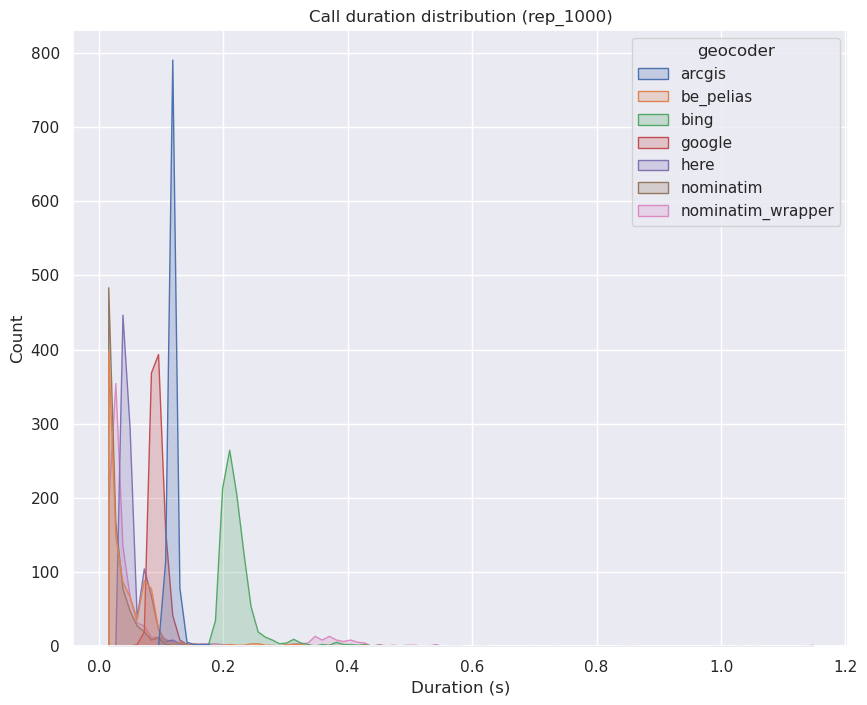

In [738]:
plt.figure(figsize=def_figsize)
sbn.histplot(geocoded_data_duration[geocoded_data_duration.duration<geocoded_data_duration.duration.quantile(0.999)].sort_values("geocoder"), 
             x="duration", hue="geocoder", element="poly",
            bins=100).set(title=f'Call duration distribution ({dataset})', xlabel="Duration (s)")

pdf_savefig()
    

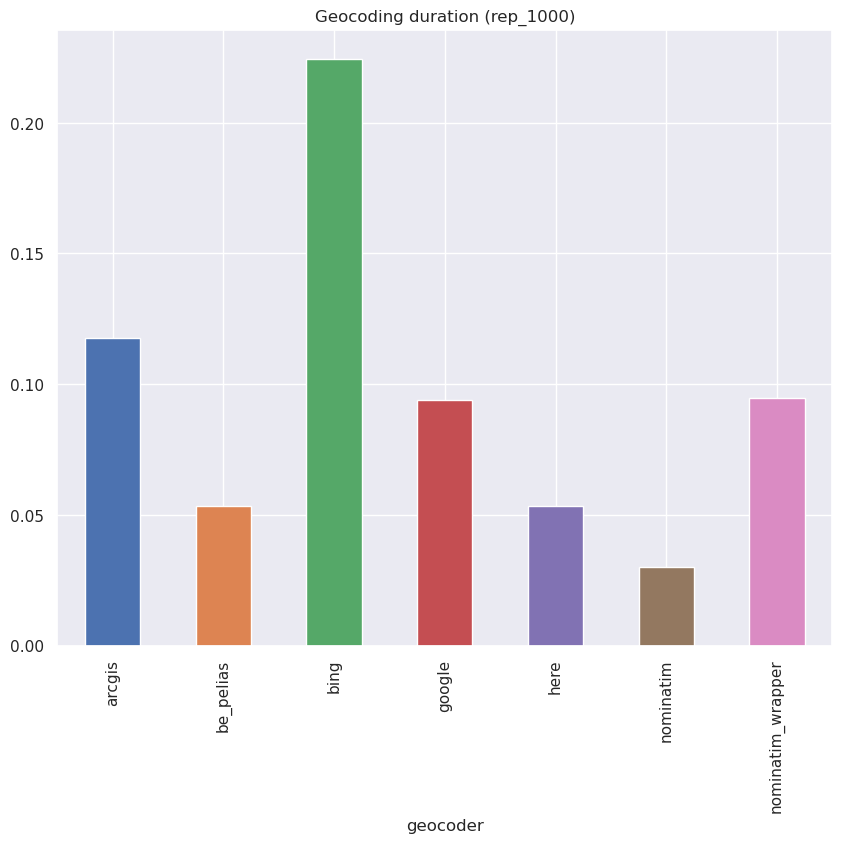

In [739]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, 
                                                                    title=f"Geocoding duration ({dataset})",
                                                                   figsize=def_figsize)
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

<Axes: title={'center': 'Geocoding duration (rep_1000)'}, xlabel='geocoder'>

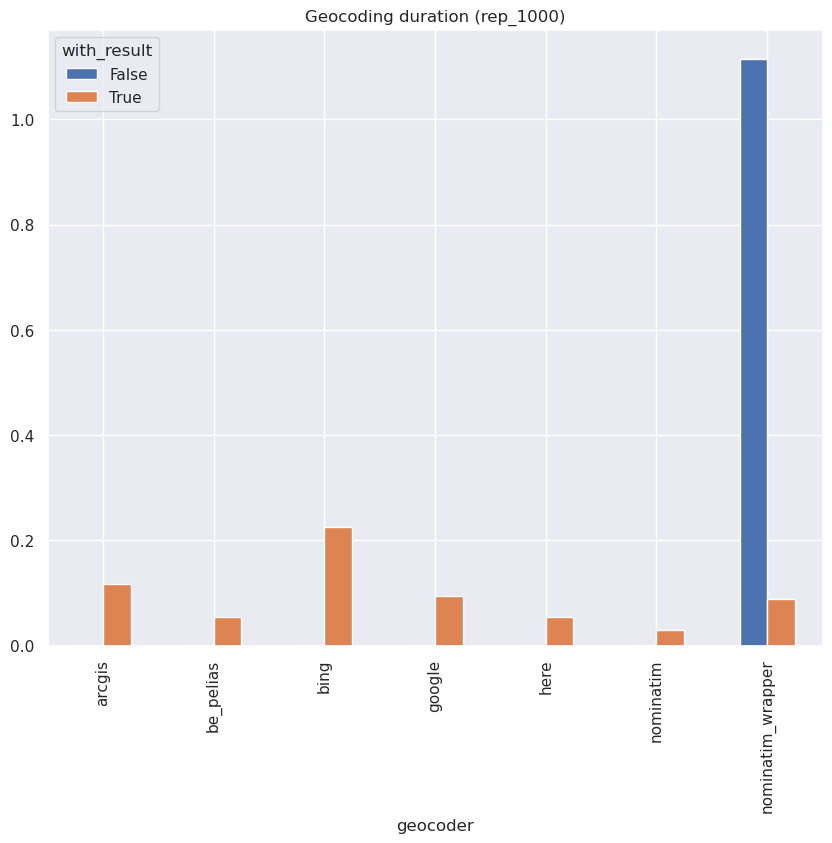

In [740]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})",
                                                                                              figsize=def_figsize)

In [741]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

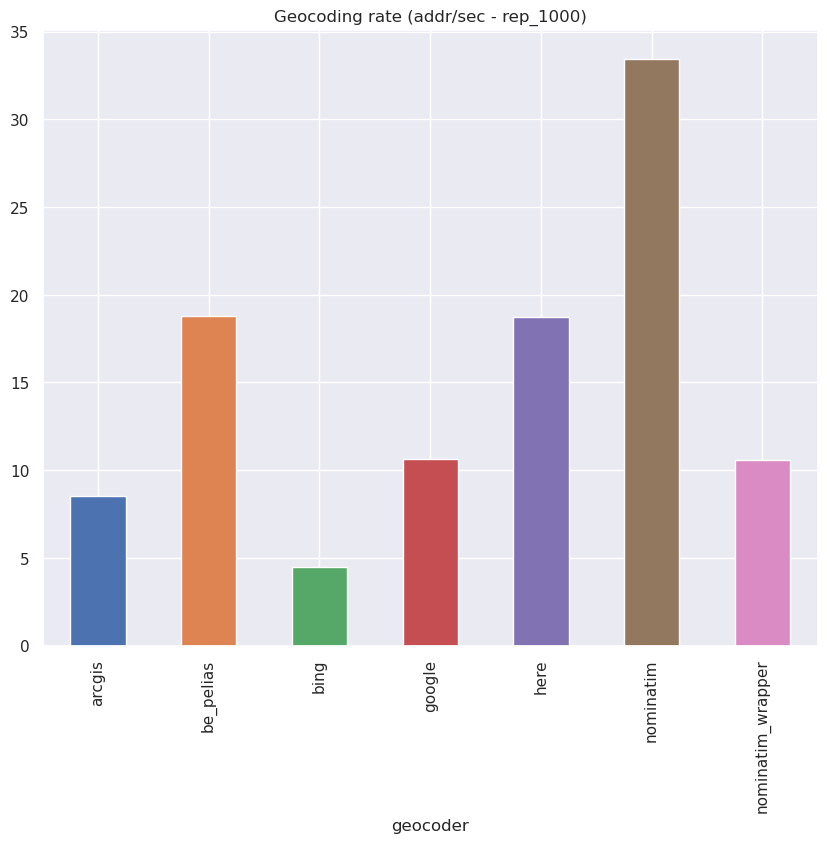

In [742]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, 
                                                                        title=f"Geocoding rate (addr/sec - {dataset})",
                                                                        figsize=def_figsize)
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

# Matching rate

## Matching rate

In [743]:
# geocoded_data[geocoded_data.geocoder=="jcd"].reference_key.isnull().value_counts()

In [744]:
data

reference_key            street housenumber postcode             city  \
0                0    de Burburelaan          46     1970  Wezembeek-Oppem   
1                1   Nachtegalenlaan          35     1950         Kraainem   
2                2     Rue Tilia(ST)          12     6511         Beaumont   
3                3    Rue du Hock(N)          36     4121           Neupré   
4                4   Wuustwezelseweg          95     2990       Wuustwezel   
..             ...               ...         ...      ...              ...   
995            995        Lichterweg           3     2030        Antwerpen   
996            996  Grote Markt(Kor)          41     8500         Kortrijk   
997            997     Heerweg-Noord          72     9052             Gent   
998            998        Mechelbaan         750     2580            Putte   
999            999     Dikkebusseweg         126     8900            Ieper   

                                               address  
0    de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...  
1         Nachtegalenlaan, 35, 1950 Kraainem, Belgique  
2           Rue Tilia(ST), 12, 6511 Beaumont, Belgique  
3            Rue du Hock(N), 36, 4121 Neupré, Belgique  
4       Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique  
..                                                 ...  
995            Lichterweg, 3, 2030 Antwerpen, Belgique  
996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique  
997             Heerweg-Noord, 72, 9052 Gent, Belgique  
998              Mechelbaan, 750, 2580 Putte, Belgique  
999           Dikkebusseweg, 126, 8900 Ieper, Belgique  

[1000 rows x 6 columns]

In [745]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

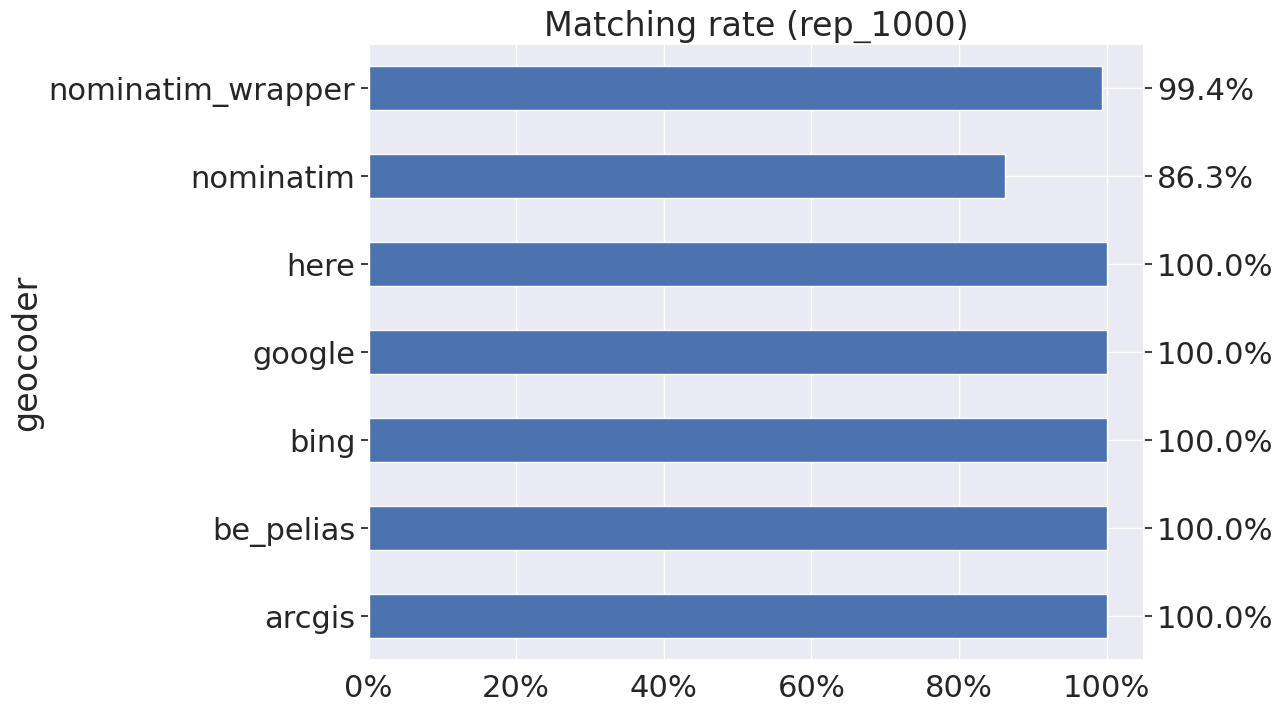

In [746]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')   
    
    


plt.figure(figsize=def_figsize)
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)


mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf_savefig()

sbn.set(font_scale=1)



In [747]:
# geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Extract precision

In [748]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [749]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

geocoder  precision                   
bing      [UNKNOWN - RoadIntersection]    1
Name: count, dtype: int64

In [750]:
geocoded_data[geocoded_data.precision.str.contains("UNK")]

street housenumber postcode    city  \
1178  Rue de la Carrière,Tattert          69     6717  Attert   

                                                address  \
1178  Rue de la Carrière,Tattert, 69, 6717 Attert, B...   

                                               location geocoder  \
1178  (Rue de la Carrière & Tattert, Attert, Walloon...     bing   

      reference_key  duration                     precision  
1178            178  0.216718  [UNKNOWN - RoadIntersection]

In [751]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

## Precision

In [752]:
mr

geocoder
arcgis               1.000
be_pelias            1.000
bing                 1.000
google               1.000
here                 1.000
nominatim            0.863
nominatim_wrapper    0.994
Name: address, dtype: float64

In [753]:
def plot_matching_rate(geocoded_data, title=f"Matching rate - Precision ({dataset})"):
    sbn.set(font_scale=2)
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    mr_prec = mr_prec/data.shape[0]
    mr_prec = mr_prec.reindex(["building", "street", "city", "country"], axis=1).reindex(coders, axis=0) # , "[UNKNOWN]"

    mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                    figsize=def_figsize, 
                                    title=title, 
                                    color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
    mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

    mr_prec_plot.set_ylabel(None)

    plt.legend(loc='lower left')

    show_values_on_hbars(mr_prec_plot, mr.reindex(coders))

    for bars in mr_prec_plot.containers:
        mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0.005 else "", fontproperties={"size":"x-small"})


    plt.savefig(f'{fig_path}/matching_rate_{dataset}.png', dpi=150,  bbox_inches='tight')

    sbn.set(font_scale=1)
    
    return mr_prec


In [754]:
import matplotlib
matplotlib.__version__


'3.8.0'

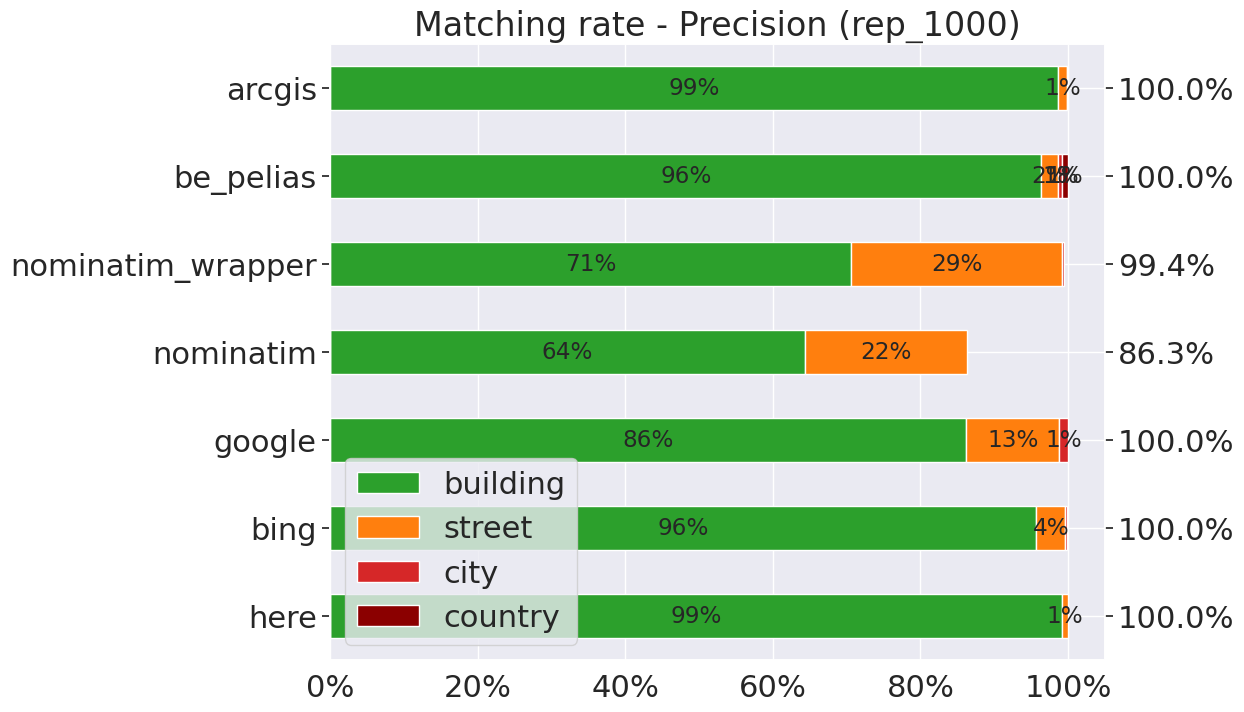

In [755]:
mr_prec = plot_matching_rate(geocoded_data)
pdf_savefig()

In [756]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))


precision          building  street city country
geocoder                                        
here                  99.2%    0.8%             
bing                  95.7%    3.9% 0.3%        
google                86.2%   12.6% 1.2%        
nominatim             64.3%   22.0%             
nominatim_wrapper     70.6%   28.6% 0.2%        
be_pelias             96.4%    2.3% 0.5%    0.8%
arcgis                98.6%    1.3% 0.1%

In [757]:
# kbo: ngi_pelias	93.4%	5.6%	0.9%	0.1%
#                   94.6%	4.5%	0.8%	0.1%
# rep: 94.4%	5.1%	0.4%	0.1%
#      95.8%	3.1%	0.4%	0.7%

# rrn: 97.3%	1.3%	0.3%	1.1%

geocoded_data[(geocoded_data.geocoder=="be_pelias_simple") & (geocoded_data.precision=="street")]

Empty DataFrame
Columns: [street, housenumber, postcode, city, address, location, geocoder, reference_key, duration, precision]
Index: []

In [758]:
# geocoded_data.loc[67].location.raw

In [759]:
geocoded_data[geocoded_data.geocoder=="be_pelias_simple"].location.apply(lambda rec: rec.raw["bepelias"]["call_type"]).value_counts()

Series([], Name: count, dtype: int64)

In [760]:
pd.crosstab(geocoded_data[geocoded_data.geocoder=="be_pelias_simple"].location.apply(lambda rec: "openaddress" in rec.raw["properties"]["gid"]),
            geocoded_data[geocoded_data.geocoder=="be_pelias_simple"].precision)

Empty DataFrame
Columns: []
Index: []

In [761]:
# geocoded_data[~geocoded_data.location.apply(lambda rec: "openaddress" in rec.raw["properties"]["gid"]) & (geocoded_data.precision=="building")]

In [762]:
# geocoded_data.loc[0].location.raw

{'Relevance': 1.0,
 'MatchLevel': 'houseNumber',
 'MatchQuality': {'Country': 1.0,
  'City': 1.0,
  'Street': [0.7],
  'HouseNumber': 1.0,
  'PostalCode': 1.0},
 'MatchType': 'pointAddress',
 'Location': {'LocationId': 'NT_4OPfs3cy1JBEWkTIpnnY0A_0YD',
  'LocationType': 'point',
  'DisplayPosition': {'Latitude': 50.85152, 'Longitude': 4.47889},
  'NavigationPosition': [{'Latitude': 50.85174, 'Longitude': 4.47868}],
  'MapView': {'TopLeft': {'Latitude': 50.8526442, 'Longitude': 4.4771094},
   'BottomRight': {'Latitude': 50.8503958, 'Longitude': 4.4806706}},
  'Address': {'Label': 'Oscar de Burburelaan 46, 1970 Wezembeek-Oppem, België',
   'Country': 'BEL',
   'State': 'Vlaanderen',
   'County': 'Vlaams Brabant',
   'City': 'Wezembeek-Oppem',
   'Street': 'Oscar de Burburelaan',
   'HouseNumber': '46',
   'PostalCode': '1970',
   'AdditionalData': [{'value': 'België', 'key': 'CountryName'},
    {'value': 'Vlaanderen', 'key': 'StateName'},
    {'value': 'Vlaams Brabant', 'key': 'CountyName

In [763]:
# geocoded_data
addr_in_bru = geocoded_data[geocoded_data.postcode.astype(int).between(1000, 1299)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 

# mr_prec = plot_matching_rate(geocoded_data_bru, f"Matching rate - Precision (within Brussels - {dataset})")
# pdf_savefig()

In [764]:
# geocoded_data_bru[geocoded_data_bru.geocoder=="pelias"]

location
struct - *                         524
struct - clean;no_city             209
unstruct - *                       133
struct - clean                      74
unstruct - clean;no_city            19
unstruct - clean                    15
unstruct - no_city;no_hn             5
struct - clean_hn                    5
struct - no_city;clean_hn            5
unstruct - clean_hn                  4
unstruct - no_city                   4
struct - no_city;no_hn               1
struct - clean;no_city;clean_hn      1
unstruct - no_city;clean_hn          1
Name: count, dtype: int64

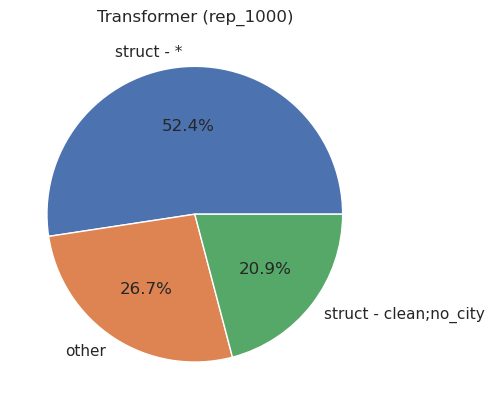

In [765]:
if "be_pelias" in geocoded_data.geocoder.unique():
    vc = geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: rec.raw["bepelias"]["call_type"]+" - "+(rec.raw["bepelias"]["transformers"] or "*")).value_counts()
    display(vc)
    
    _vc = vc.reset_index()
    _vc.location = _vc.location.where(_vc["count"]>200, "other")
    _vc.groupby("location")["count"].sum().sort_values(ascending=False).rename("").plot.pie(autopct='%1.1f%%', 
                                                                                 title=f"Transformer ({dataset})")

#     vc.plot.pie()

In [766]:
# _vc.groupby("location")["count"].sum().sort_values(ascending=False)
geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: "interpolated" in rec.raw["bepelias"]).value_counts()

location
False    996
True       4
Name: count, dtype: int64

In [767]:
geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

location
exact           946
interpolated     31
fallback         23
Name: count, dtype: int64

In [768]:
pd.crosstab(geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: rec.raw["properties"]["match_type"]),
            geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: "interpolated" in rec.raw["bepelias"])
           )

location      False  True 
location                  
exact           942      4
fallback         23      0
interpolated     31      0

In [769]:
bp = geocoded_data[geocoded_data.geocoder=="be_pelias"]
bp[bp.location.apply(lambda loc: loc.raw["properties"]["match_type"] == "interpolated")]

street housenumber postcode                  city  \
5015                   Oude Baan         135     3290                 Diest   
5079                 Auf der Höh           7     4701                 Eupen   
5084             Ertbruggestraat          57     2110              Wijnegem   
5088                 Groenstraat       14-16     1800             Vilvoorde   
5108            Poortakkerstraat       13-15     9051                  Gent   
5135                 Zonnestraat           4     9160               Lokeren   
5141              Weygaardstraat          63     3530  Houthalen-Helchteren   
5145           Rue de la Régence       25-27     6000             Charleroi   
5186               Rue Noirivaux          23     4870                 Trooz   
5194                  Marktplein           2     9860            Oosterzele   
5222              Rue Noël Heine          98     4340                 Awans   
5228        Avenue des Cerisiers           3     1330             Rixensart   
5277                  Beekstraat       54-56     3800          Sint-Truiden   
5293               Vlinderstraat          24     2260              Westerlo   
5321                 Breite Wege           1     4730                Raeren   
5371      Franklin Rooseveltlaan     172-174     8790               Waregem   
5447           Augustijnenstraat       49-51     2800              Mechelen   
5484               Zonienboslaan          20     3090              Overijse   
5530        Blijde-Inkomststraat     103-105     3000                Leuven   
5544              Rue des Nutons         329     6060             Charleroi   
5590          Doornikselaan(Kor)         3-4     8500              Kortrijk   
5625           Rue de Baume(L.L)         377     7100           La Louvière   
5656                 Brechtseweg         208     2990            Wuustwezel   
5696  Rue Docteur Emile Neuville         5 B     4530   Villers-le-Bouillet   
5737                      Haloup           4     6880               Bertrix   
5747           Rue de la Bruyère         194     1332             Rixensart   
5805                  Lentedreef           3     2360          Oud-Turnhout   
5834    Hendrik Consciencestraat       18-20     2800              Mechelen   
5868                    Moerelei     119-121     2610             Antwerpen   
5956             Avenue de Rohan          39     1420       Braine-l'Alleud   
5999               Dikkebusseweg         126     8900                 Ieper   

                                                address  \
5015               Oude Baan, 135, 3290 Diest, Belgique   
5079               Auf der Höh, 7, 4701 Eupen, Belgique   
5084       Ertbruggestraat, 57, 2110 Wijnegem, Belgique   
5088       Groenstraat, 14-16, 1800 Vilvoorde, Belgique   
5108       Poortakkerstraat, 13-15, 9051 Gent, Belgique   
5135             Zonnestraat, 4, 9160 Lokeren, Belgique   
5141  Weygaardstraat, 63, 3530 Houthalen-Helchteren,...   
5145  Rue de la Régence, 25-27, 6000 Charleroi, Belg...   
5186            Rue Noirivaux, 23, 4870 Trooz, Belgique   
5194           Marktplein, 2, 9860 Oosterzele, Belgique   
5222           Rue Noël Heine, 98, 4340 Awans, Belgique   
5228  Avenue des Cerisiers, 3, 1330 Rixensart, Belgique   
5277     Beekstraat, 54-56, 3800 Sint-Truiden, Belgique   
5293         Vlinderstraat, 24, 2260 Westerlo, Belgique   
5321              Breite Wege, 1, 4730 Raeren, Belgique   
5371  Franklin Rooseveltlaan, 172-174, 8790 Waregem,...   
5447  Augustijnenstraat, 49-51, 2800 Mechelen, Belgique   
5484         Zonienboslaan, 20, 3090 Overijse, Belgique   
5530  Blijde-Inkomststraat, 103-105, 3000 Leuven, Be...   
5544      Rue des Nutons, 329, 6060 Charleroi, Belgique   
5590   Doornikselaan(Kor), 3-4, 8500 Kortrijk, Belgique   
5625  Rue de Baume(L.L), 377, 7100 La Louvière, Belg...   
5656        Brechtseweg, 208, 2990 Wuustwezel, Belgique   
5696  Rue Docteur Emile Neuville, 5 B, 4530 Villers-...   
5737                  

In [770]:
# bp.loc[47].location.raw

In [771]:
# bp[bp.location.apply(lambda loc: "interpolated" in loc.raw["bepelias"])]

In [772]:
# bp.loc[9955].location.raw

# Distance to median statistics

## Extract location

In [773]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc and loc.point.latitude >0 else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [774]:
geocoded_data[geocoded_data.point.isnull()]

street housenumber postcode  \
5040            Rue Taille Gabelle           2     6530   
5150                   Place Verte          20     6000   
5197         Place Sainte Ode(AMA)           3     4540   
5306      Chaussée de Tournai(Irc)         184     7801   
5401  Rue Antoine de Saint-Exupéry           2     6041   
5588     Rue des Droits de l'Homme         5-3     7160   
5921  Rue Isidore-Derèse,Mornimont         155     5190   
5995                    Lichterweg           3     2030   

                         city  \
5040                    Thuin   
5150                Charleroi   
5197                     Amay   
5306                      Ath   
5401                Charleroi   
5588  Chapelle-lez-Herlaimont   
5921       Jemeppe-sur-Sambre   
5995                Antwerpen   

                                                address  \
5040        Rue Taille Gabelle, 2, 6530 Thuin, Belgique   
5150          Place Verte, 20, 6000 Charleroi, Belgique   
5197      Place Sainte Ode(AMA), 3, 4540 Amay, Belgique   
5306  Chaussée de Tournai(Irc), 184, 7801 Ath, Belgique   
5401  Rue Antoine de Saint-Exupéry, 2, 6041 Charlero...   
5588  Rue des Droits de l'Homme, 5-3, 7160 Chapelle-...   
5921  Rue Isidore-Derèse,Mornimont, 155, 5190 Jemepp...   
5995            Lichterweg, 3, 2030 Antwerpen, Belgique   

                                               location   geocoder  \
5040       (Rue Taille Gabelle, 6530 Thuin, (0.0, 0.0))  be_pelias   
5150      (20, Place Verte, 6000 Charleroi, (0.0, 0.0))  be_pelias   
5197       (3, Place Sainte-Ode, 4540 Amay, (0.0, 0.0))  be_pelias   
5306   (184, Chaussée de Tournai, 7801 Ath, (0.0, 0.0))  be_pelias   
5401  (2, Rue Antoine de Saint-Exupéry, 6041 Charler...  be_pelias   
5588  (5, Rue des Droits de l'Homme, 7160 Chapelle-l...  be_pelias   
5921  (155, Rue Isidore Derèse, 5190 Jemeppe-sur-Sam...  be_pelias   
5995           (Lichterweg, 2000 Antwerpen, (0.0, 0.0))  be_pelias   

      reference_key  duration precision point  
5040             40  0.258997   country  <NA>  
5150            150  0.123723   country  <NA>  
5197            197  0.060891   country  <NA>  
5306            306  0.090567   country  <NA>  
5401            401  0.111248   country  <NA>  
5588            588  0.242738   country  <NA>  
5921            921  0.086744   country  <NA>  
5995            995  0.211199   country  <NA>

<Axes: >

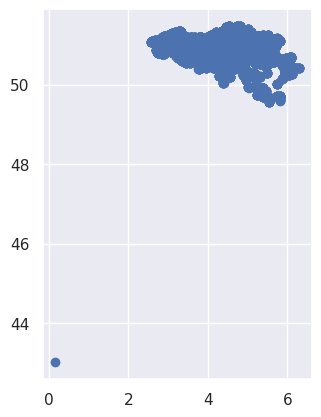

In [775]:
geocoded_data[geocoded_data.point.notnull()].set_geometry("point").plot()

In [776]:
geocoded_data = geocoded_data[geocoded_data.point.notnull()] 

In [777]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

street housenumber postcode             city  \
0       de Burburelaan          46     1970  Wezembeek-Oppem   
1      Nachtegalenlaan          35     1950         Kraainem   
2        Rue Tilia(ST)          12     6511         Beaumont   
3       Rue du Hock(N)          36     4121           Neupré   
4      Wuustwezelseweg          95     2990       Wuustwezel   
...                ...         ...      ...              ...   
6995        Lichterweg           3     2030        Antwerpen   
6996  Grote Markt(Kor)          41     8500         Kortrijk   
6997     Heerweg-Noord          72     9052             Gent   
6998        Mechelbaan         750     2580            Putte   
6999     Dikkebusseweg         126     8900            Ieper   

                                                address  \
0     de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
1          Nachtegalenlaan, 35, 1950 Kraainem, Belgique   
2            Rue Tilia(ST), 12, 6511 Beaumont, Belgique   
3             Rue du Hock(N), 36, 4121 Neupré, Belgique   
4        Wuustwezelseweg, 95, 2990 Wuustwezel, Belgique   
...                                                 ...   
6995            Lichterweg, 3, 2030 Antwerpen, Belgique   
6996      Grote Markt(Kor), 41, 8500 Kortrijk, Belgique   
6997             Heerweg-Noord, 72, 9052 Gent, Belgique   
6998              Mechelbaan, 750, 2580 Putte, Belgique   
6999           Dikkebusseweg, 126, 8900 Ieper, Belgique   

                                               location geocoder  \
0     (Oscar de Burburelaan 46, 1970 Wezembeek-Oppem...     here   
1     (Nachtegalenlaan 35, 1950 Kraainem, België, Kr...     here   
2     (Rue Tilia 12, 6511 Beaumont, Belgique, Beaumo...     here   
3     (Rue du Hock 36, 4121 Neupré, Belgique, Neupré...     here   
4     (Wuustwezelseweg 95, 2990 Wuustwezel, België, ...     here   
...                                                 ...      ...   
6995  (Lichterweg, 2030, Antwerpen, (51.249208633671...   arcgis   
6996  (Grote Markt 41, 8500, Kortrijk, (50.827133139...   arcgis   
6997  (Heerweg-Noord 72, 9052, Gent, (51.00593547849...   arcgis   
6998  (Mechelbaan 750, 2580, Putte, (51.038325792662...   arcgis   
6999  (Dikkebusseweg 126, 8900, Ieper, (50.842279504...   arcgis   

      reference_key  duration precision                           point  
0                 0  0.258693  building  POINT (498587.754 6595071.237)  
1                 1  0.045044  building  POINT (497812.970 6595975.832)  
2                 2  0.079674  building  POINT (479080.127 6493708.716)  
3                 3  0.059474  building  POINT (607320.180 6542691.616)  
4                 4  0.043009  building  POINT (515080.850 6692445.651)  
...             ...       ...       ...                             ...  
6995            995  0.124379    street  POINT (488340.927 6665494.797)  
6996            996  0.116532  building  POINT (363455.476 6590772.353)  
6997            997  0.115367  building  POINT (413752.449 6622343.707)  
6998            998  0.114075  building  POINT (509467.098 6628075.914)  
6999            999  0.113133  building  POINT (319745.953 6593442.070)  

[6849 rows x 11 columns]

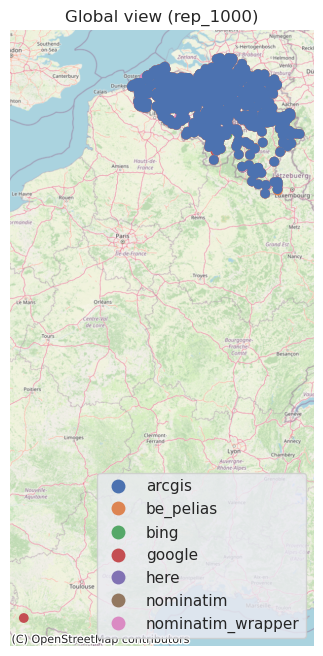

In [778]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data.plot("geocoder", legend=True, figsize=def_figsize, cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf_savefig()
# plt.show()
# plt.close()

In [779]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [780]:
import fiona

In [781]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

is_in_belgium
True     6848
False       1
Name: count, dtype: int64

In [782]:
geocoded_data[~geocoded_data.is_in_belgium]

street housenumber postcode      city  \
2878  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   

                                                address  \
2878  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   

                                               location geocoder  \
2878  (Hautes-Pyrénées, France, (43.0193924, 0.14949...   google   

      reference_key  duration precision                          point  \
2878            878  0.114495      city  POINT (16642.130 5314924.034)   

      is_in_belgium  
2878          False

In [783]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder           is_in_belgium
arcgis             True             1000
be_pelias          True              992
bing               True             1000
google             True              999
                   False               1
here               True             1000
nominatim          True              863
nominatim_wrapper  True              994
Name: count, dtype: int64

In [784]:
geocoded_data[~geocoded_data.is_in_belgium]

street housenumber postcode      city  \
2878  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   

                                                address  \
2878  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   

                                               location geocoder  \
2878  (Hautes-Pyrénées, France, (43.0193924, 0.14949...   google   

      reference_key  duration precision                          point  \
2878            878  0.114495      city  POINT (16642.130 5314924.034)   

      is_in_belgium  
2878          False

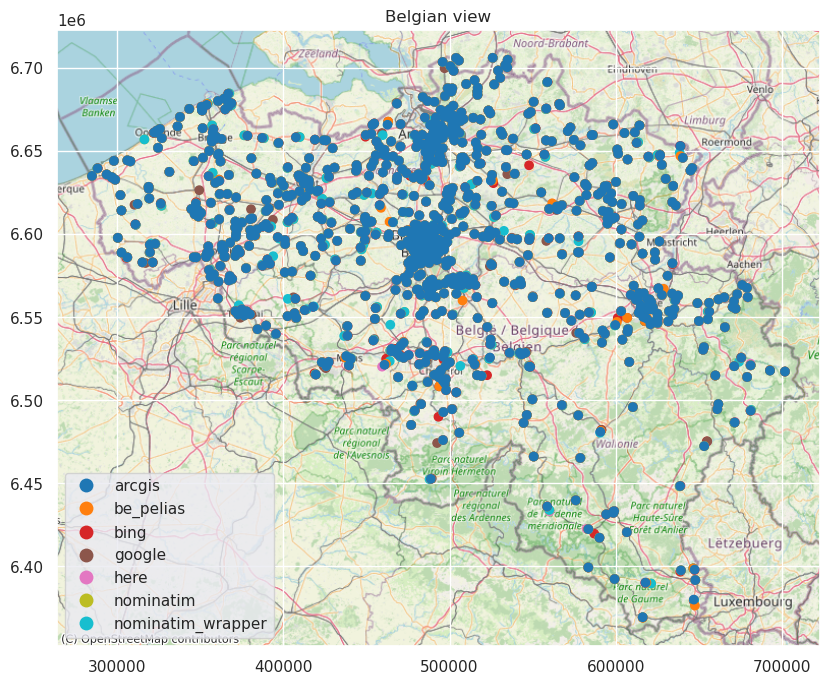

In [785]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=def_figsize)
plt.title("Belgian view")
add_basemap(ax)
pdf_savefig()

## Compute (distance to) median

In [786]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [787]:
# geocoded_data.address.drop_duplicates()

In [788]:
median_geocoders = coders # ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

address  \
0               't Vlietje, 4, 2800 Mechelen, Belgique   
1        Aalstersesteenweg, 362, 9400 Ninove, Belgique   
2         Aaltersesteenweg, 122, 9800 Deinze, Belgique   
3        Aarschotsesteenweg, 22, 3012 Leuven, Belgique   
4    Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique   
..                                                 ...   
995  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
996  de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique   
997  de Smet de Naeyerlaan, 526, 1020 Brussel, Belg...   
998   rue des Maraîchers, 9, 1070 Anderlecht, Belgique   
999           rue du Chenia, 15, 7170 Manage, Belgique   

                       median_point  nb_points  
0    POINT (499196.403 6626069.331)          7  
1    POINT (449065.052 6596429.049)          5  
2    POINT (389867.998 6620321.392)          7  
3    POINT (524103.295 6601928.736)          7  
4    POINT (527891.497 6611051.147)          5  
..                              ...        ...  
995  POINT (498585.561 6595073.888)          5  
996  POINT (480145.930 6604319.379)          5  
997  POINT (483041.328 6600914.669)          5  
998  POINT (478803.897 6592983.817)          7  
999  POINT (472189.450 6534554.111)          3  

[1000 rows x 3 columns]

<Axes: ylabel='count'>

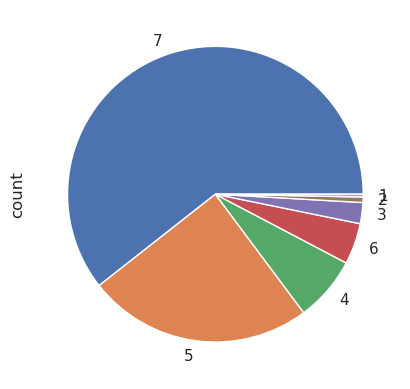

In [789]:
median_points.nb_points.value_counts().plot.pie()

In [790]:
median_points = median_points[median_points.nb_points >= min(3,median_points.nb_points.max()) ]
median_points.shape

(991, 3)

In [791]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [792]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

street housenumber postcode            city  \
4344                  Watervoort(HRT)          75     2200       Herentals   
4892                          Boshoek          43     2560          Nijlen   
6583            Avenue Eugène Mascaux         537     6001       Charleroi   
1124                Kasteelhoekstraat           1     1820  Steenokkerzeel   
5102                       Kasteellei          59     2930      Brasschaat   
...                               ...         ...      ...             ...   
6250     Rue Antoine de Saint-Exupéry           2     6041       Charleroi   
6269  Zoning de Jumet,avenue Centrale          33     6040       Charleroi   
6274       Avenue du Centenaire,H.-M.           6     1320     Beauvechain   
6580          Rue du Mont d'Orcq(FRY)          14     7503         Tournai   
6844                       Lichterweg           3     2030       Antwerpen   

                                                address  \
4344      Watervoort(HRT), 75, 2200 Herentals, Belgique   
4892                 Boshoek, 43, 2560 Nijlen, Belgique   
6583  Avenue Eugène Mascaux, 537, 6001 Charleroi, Be...   
1124  Kasteelhoekstraat, 1, 1820 Steenokkerzeel, Bel...   
5102          Kasteellei, 59, 2930 Brasschaat, Belgique   
...                                                 ...   
6250  Rue Antoine de Saint-Exupéry, 2, 6041 Charlero...   
6269  Zoning de Jumet,avenue Centrale, 33, 6040 Char...   
6274  Avenue du Centenaire,H.-M., 6, 1320 Beauvechai...   
6580  Rue du Mont d'Orcq(FRY), 14, 7503 Tournai, Bel...   
6844            Lichterweg, 3, 2030 Antwerpen, Belgique   

                                               location           geocoder  \
4344  (75, Watervoort, Herentals, Turnhout, Antwerpe...  nominatim_wrapper   
4892    (43, Boshoek, 2560 Nijlen, (51.16217, 4.69101))          be_pelias   
6583  (Avenue Eugène Mascaux 537, 6001, Charleroi, (...             arcgis   
1124  (Kasteelhoekstraat 1, Steenokkerzeel, Flemish ...               bing   
5102  (59, Kasteellei, 2930 Brasschaat, (51.27695, 4...          be_pelias   
...                                                 ...                ...   
6250  (Rue Antoine de Saint-Exupéry, 6041, Charleroi...             arcgis   
6269  (Zoning de Jumet, 6040, Charleroi, Jumet, (50....             arcgis   
6274  (Avenue du Centenaire, 1320, Beauvechain, Hamm...             arcgis   
6580  (Rue du Mont d'Orcq 14, 7503, Tournai, Froyenn...             arcgis   
6844  (Lichterweg, 2030, Antwerpen, (51.249208633671...             arcgis   

      reference_key  duration precision                           point  \
4344            485  0.409580  building  POINT (538168.556 6657198.308)   
4892             35  0.020039  building  POINT (522200.845 6650030.006)   
6583            734  0.115580  building  POINT (493635.311 6513715.821)   
1124            124  0.192125  building  POINT (501428.950 6608997.763)   
5102            248  0.017841  building  POINT (496647.455 6670429.959)   
...             ...       ...       ...                             ...   
6250            401  0.127066    street  POINT (496924.403 6528123.475)   
6269            420  0.137308    street  POINT (496410.597 6525913.632)   
6274            425  0.129141    street  POINT (524919.069 6581922.946)   
6580            731  0.128162  building  POINT (371825.474 6553426.118)   
6844            995  0.124379    street  POINT (488340.927 6665494.797)   

      is_in_belgium                    median_point  nb_points  dist_to_median  
4344           True  POINT (538168.556 6657198.308)        5.0             0.0  
4892           True  POINT (522200.845 6650030.006)        7.0             0.0  
6583           True  POINT (493635.311 6513715.821)        7.0             0.0  
1124           True  POINT (501428.950 6608997.763)        5.0             0.0  
5102           True  POINT (496647.455 6670429.959)        7.0             0.0  
...             ...                             ...        ..

In [793]:
# geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

In [794]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [795]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=def_figsize
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

In [796]:
# plot_address(geocoded_data, geocoded_data.loc[46].address)

street housenumber postcode      city  \
878   Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
1878  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
2878  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
4737  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
5729  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   
6727  Rue de la Croix-Rouge, Bos.          65     5032  Gembloux   

                                                address  \
878   Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
1878  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
2878  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
4737  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
5729  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   
6727  Rue de la Croix-Rouge, Bos., 65, 5032 Gembloux...   

                                               location           geocoder  \
878   (Rue de la Croix-Rouge 65, 5032 Gembloux, Belg...               here   
1878  (Rue de la Croix Rouge 65, Gembloux, Walloon R...               bing   
2878  (Hautes-Pyrénées, France, (43.0193924, 0.14949...             google   
4737  (65, Rue de la Croix Rouge, Golzinne, Bossière...  nominatim_wrapper   
5729  (65, Rue de la Croix-Rouge, 5032 Gembloux, (50...          be_pelias   
6727  (Rue de la Croix-Rouge 65, 5032, Gembloux, (50...             arcgis   

      reference_key  duration precision                           point  \
878             878  0.093710  building  POINT (524748.948 6536502.095)   
1878            878  0.273198  building  POINT (524748.480 6536502.516)   
2878            878  0.114495      city   POINT (16642.130 5314924.034)   
4737            878  0.360674  building  POINT (524748.479 6536502.524)   
5729            878  0.084433  building  POINT (524748.948 6536502.095)   
6727            878  0.120189  building  POINT (524748.485 6536502.518)   

      is_in_belgium                    median_point  nb_points  dist_to_median  
878            True  POINT (524748.485 6536502.516)        5.0    6.249231e-01  
1878           True  POINT (524748.485 6536502.516)        5.0    4.967966e-03  
2878          False  POINT (524748.485 6536502.516)        5.0    1.323037e+06  
4737           True  POINT (524748.485 6536502.516)        5.0    1.038111e-02  
5729           True  POINT (524748.485 6536502.516)        5.0    6.249231e-01  
6727           True  POINT (524748.485 6536502.516)        5.0    2.826785e-03

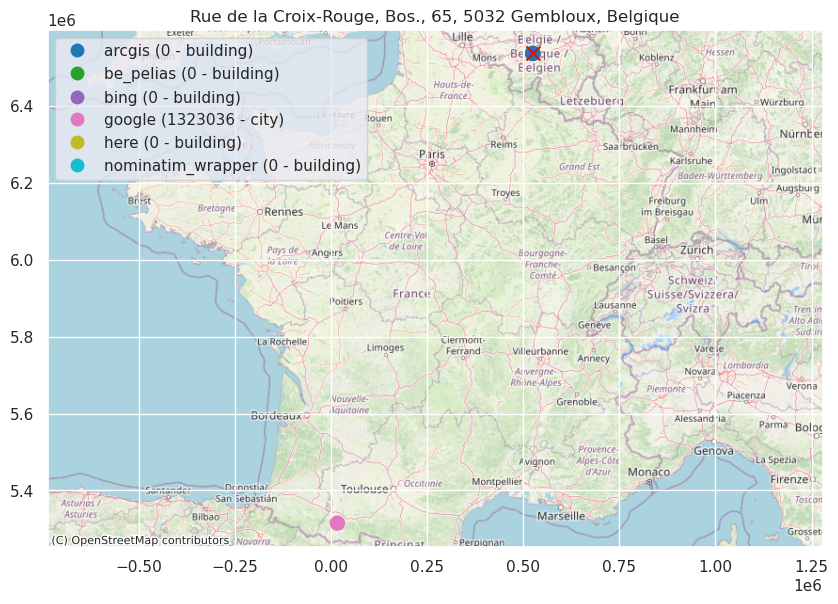

street housenumber postcode   city  \
97    Rue de l'Industrie           2     1301  Wavre   
1097  Rue de l'Industrie           2     1301  Wavre   
2097  Rue de l'Industrie           2     1301  Wavre   
3959  Rue de l'Industrie           2     1301  Wavre   
4953  Rue de l'Industrie           2     1301  Wavre   
5946  Rue de l'Industrie           2     1301  Wavre   

                                          address  \
97    Rue de l'Industrie, 2, 1301 Wavre, Belgique   
1097  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
2097  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
3959  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
4953  Rue de l'Industrie, 2, 1301 Wavre, Belgique   
5946  Rue de l'Industrie, 2, 1301 Wavre, Belgique   

                                               location           geocoder  \
97    (Rue de l'Industrie 2, 1301 Wavre, Belgique, W...               here   
1097  (Rue de l'industrie 2, Wavre, Walloon Region 1...               bing   
2097  (Rue de l'Industrie 2, 1301 Wavre, Belgium, (5...             google   
3959  (Rue de l'Industrie, Loncin, Ans, Liège, Wallo...  nominatim_wrapper   
4953  (2, Rue de l'Industrie, 1301 Wavre, (50.7059, ...          be_pelias   
5946  (Rue de l'Industrie 2, 1301, Wavre, (50.705903...             arcgis   

      reference_key  duration precision                           point  \
97               97  0.041210  building  POINT (511584.305 6569415.462)   
1097             97  0.220802  building  POINT (511568.787 6569416.745)   
2097             97  0.097393  building  POINT (511591.407 6569439.895)   
3959             97  1.736081    street  POINT (612645.560 6563235.891)   
4953             97  0.039237  building  POINT (511592.097 6569434.798)   
5946             97  0.127935  building  POINT (511592.032 6569435.404)   

      is_in_belgium                    median_point  nb_points  dist_to_median  
97             True  POINT (511591.407 6569434.798)        5.0       20.598509  
1097           True  POINT (511591.407 6569434.798)        5.0       28.940506  
2097           True  POINT (511591.407 6569434.798)        5.0        5.097521  
3959           True  POINT (511591.407 6569434.798)        5.0   101244.102275  
4953           True  POINT (511591.407 6569434.798)        5.0        0.690181  
5946           True  POINT (511591.407 6569434.798)        5.0        0.871348

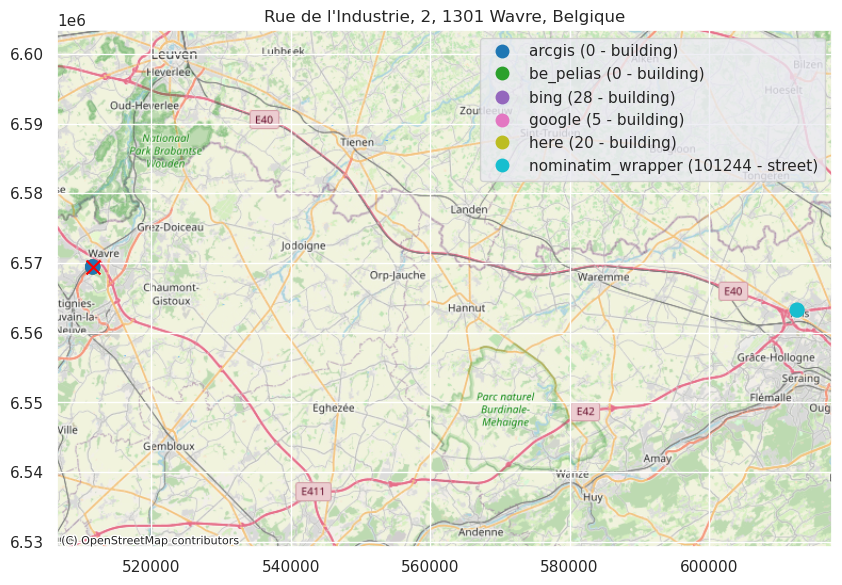

street housenumber postcode       city  \
562   Rue Dieudonné Lefèvre           2     1020  Bruxelles   
1562  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
2562  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
3486  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
4421  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
5414  Rue Dieudonné Lefèvre           2     1020  Bruxelles   
6411  Rue Dieudonné Lefèvre           2     1020  Bruxelles   

                                                address  \
562   Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
1562  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
2562  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
3486  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
4421  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
5414  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   
6411  Rue Dieudonné Lefèvre, 2, 1020 Bruxelles, Belg...   

                                               location           geocoder  \
562   (Rue Dieudonné Lefèvre 2, 1020 Bruxelles, Belg...               here   
1562  (Rue François Dieudonné 2, La Louvière, Walloo...               bing   
2562  (Rue Dieudonné Lefèvre 2, 1020 Bruxelles, Belg...             google   
3486  (Rue Dieudonné Lefèvre - Dieudonné Lefèvrestra...          nominatim   
4421  (Rue Dieudonné Lefèvre - Dieudonné Lefèvrestra...  nominatim_wrapper   
5414  (Rue Dieudonné Lefèvre, 1020 Bruxelles, (50.87...          be_pelias   
6411  (Rue Dieudonné Lefèvre, 1020, Bruxelles, Laeke...             arcgis   

      reference_key  duration precision                           point  \
562             562  0.047112  building  POINT (483617.509 6598369.171)   
1562            562  0.213136  building  POINT (461851.754 6524885.830)   
2562            562  0.104077  building  POINT (484162.262 6598442.657)   
3486            562  0.022360    street  POINT (484007.261 6598537.471)   
4421            562  0.033187    street  POINT (484007.261 6598537.471)   
5414            562  0.279714    street  POINT (483839.480 6598453.135)   
6411            562  0.114348    street  POINT (483798.690 6598432.035)   

      is_in_belgium                    median_point  nb_points  dist_to_median  
562            True  POINT (483617.509 6598369.171)        3.0        0.000000  
1562           True  POINT (483617.509 6598369.171)        3.0    76639.084977  
2562           True  POINT (483617.509 6598369.171)        3.0      549.687356  
3486           True  POINT (483617.509 6598369.171)        3.0      424.536891  
4421           True  POINT (483617.509 6598369.171)        3.0      424.536891  
5414           True  POINT (483617.509 6598369.171)        3.0      237.320921  
6411           True  POINT (483617.509 6598369.171)        3.0      191.777322

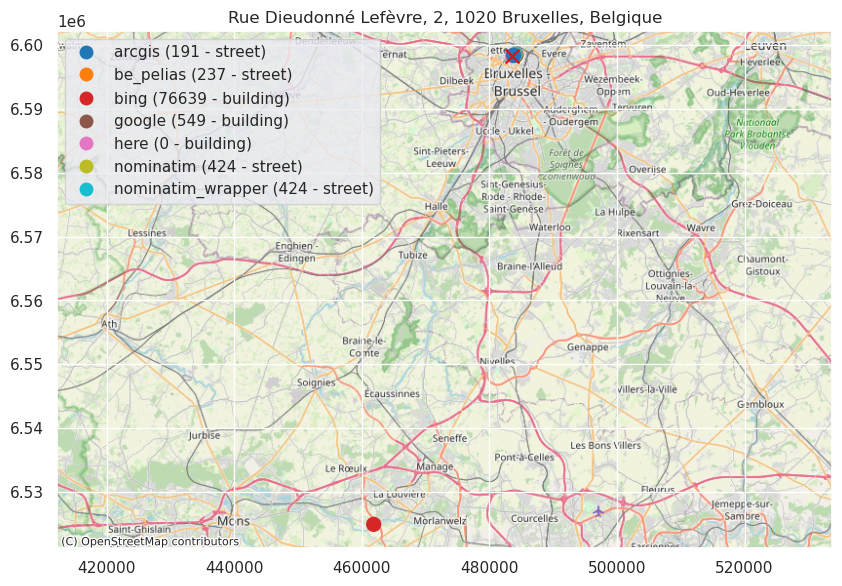

In [797]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:3]:
    #print(a)
    plot_address(geocoded_data, a)
   

## Median pertinence

How many close to median ?

In [798]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()
nb_close_to_median

address
't Vlietje, 4, 2800 Mechelen, Belgique                7
Aalstersesteenweg, 362, 9400 Ninove, Belgique         4
Aaltersesteenweg, 122, 9800 Deinze, Belgique          7
Aarschotsesteenweg, 22, 3012 Leuven, Belgique         7
Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique     5
                                                     ..
de Burburelaan, 46, 1970 Wezembeek-Oppem, Belgique    5
de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique     5
de Smet de Naeyerlaan, 526, 1020 Brussel, Belgique    5
rue des Maraîchers, 9, 1070 Anderlecht, Belgique      7
rue du Chenia, 15, 7170 Manage, Belgique              1
Name: close_to_median, Length: 1000, dtype: int64

In [799]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [800]:
median_points.nb_close_to_median.value_counts()

nb_close_to_median
7    563
5    164
6    112
4     90
3     37
2     13
1      7
0      5
Name: count, dtype: int64

In [801]:
median_points[median_points.nb_close_to_median>=2]

address  \
0               't Vlietje, 4, 2800 Mechelen, Belgique   
1        Aalstersesteenweg, 362, 9400 Ninove, Belgique   
2         Aaltersesteenweg, 122, 9800 Deinze, Belgique   
3        Aarschotsesteenweg, 22, 3012 Leuven, Belgique   
4    Aarschotsesteenweg, 54A, 3110 Rotselaar, Belgique   
..                                                 ...   
985          Zur Domäne, 39, 4750 Bütgenbach, Belgique   
986  de Burburelaan, 46, 1970 Wezembeek-Oppem, Belg...   
987  de Limburg Stirumlaan, 100, 1780 Wemmel, Belgique   
988  de Smet de Naeyerlaan, 526, 1020 Brussel, Belg...   
989   rue des Maraîchers, 9, 1070 Anderlecht, Belgique   

                       median_point  nb_points  nb_close_to_median  
0    POINT (499196.403 6626069.331)          7                   7  
1    POINT (449065.052 6596429.049)          5                   4  
2    POINT (389867.998 6620321.392)          7                   7  
3    POINT (524103.295 6601928.736)          7                   7  
4    POINT (527891.497 6611051.147)          5                   5  
..                              ...        ...                 ...  
985  POINT (692724.957 6517833.860)          7                   6  
986  POINT (498585.561 6595073.888)          5                   5  
987  POINT (480145.930 6604319.379)          5                   5  
988  POINT (483041.328 6600914.669)          5                   5  
989  POINT (478803.897 6592983.817)          7                   7  

[979 rows x 4 columns]

In [802]:
# nb_close_to_median.value_counts()

In [803]:
geocoded_data = geocoded_data.merge(median_points, how="left")

In [804]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [805]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

979

street housenumber postcode     city  \
750   Antoon van Osslaan           1     1120  Brussel   
1750  Antoon van Osslaan           1     1120  Brussel   
2750  Antoon van Osslaan           1     1120  Brussel   
3650  Antoon van Osslaan           1     1120  Brussel   
4609  Antoon van Osslaan           1     1120  Brussel   
5601  Antoon van Osslaan           1     1120  Brussel   
6599  Antoon van Osslaan           1     1120  Brussel   

                                            address  \
750   Antoon van Osslaan, 1, 1120 Brussel, Belgique   
1750  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
2750  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
3650  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
4609  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
5601  Antoon van Osslaan, 1, 1120 Brussel, Belgique   
6599  Antoon van Osslaan, 1, 1120 Brussel, Belgique   

                                               location           geocoder  \
750   (Antoon van Osslaan 1, 1120 Brussel, België, B...               here   
1750  (Avenue Antoon Van Oss 1/17, Brussels, Brussel...               bing   
2750  (Av. Antoon Van Oss 1, 1120 Bruxelles, Belgium...             google   
3650  (Scania Belgium nv-sa, 1, Avenue Antoon van Os...          nominatim   
4609  (Scania Belgium nv-sa, 1, Avenue Antoon van Os...  nominatim_wrapper   
5601  (1A, Antoon van Osslaan, 1120 Brussel, (50.905...          be_pelias   
6599  (Antoon van Osslaan 1, 1120, Brussel, (50.9072...             arcgis   

      reference_key  duration precision                           point  \
750             750  0.045426  building  POINT (490129.699 6604908.987)   
1750            750  0.232463  building  POINT (490392.936 6605140.517)   
2750            750  0.102215  building  POINT (490133.406 6604672.168)   
3650            750  0.028553  building  POINT (490653.796 6605555.540)   
4609            750  0.043004  building  POINT (490653.796 6605555.540)   
5601            750  0.054944  building  POINT (490419.130 6604603.586)   
6599            750  0.113048  building  POINT (490130.097 6604908.709)   

      is_in_belgium                    median_point  nb_points  \
750            True  POINT (490392.936 6604908.987)        7.0   
1750           True  POINT (490392.936 6604908.987)        7.0   
2750           True  POINT (490392.936 6604908.987)        7.0   
3650           True  POINT (490392.936 6604908.987)        7.0   
4609           True  POINT (490392.936 6604908.987)        7.0   
5601           True  POINT (490392.936 6604908.987)        7.0   
6599           True  POINT (490392.936 6604908.987)        7.0   

      dist_to_median  nb_close_to_median  
750              NaN                 0.0  
1750             NaN                 0.0  
2750             NaN                 0.0  
3650             NaN                 0.0  
4609             NaN                 0.0  
5601             NaN                 0.0  
6599             NaN                 0.0

No median point


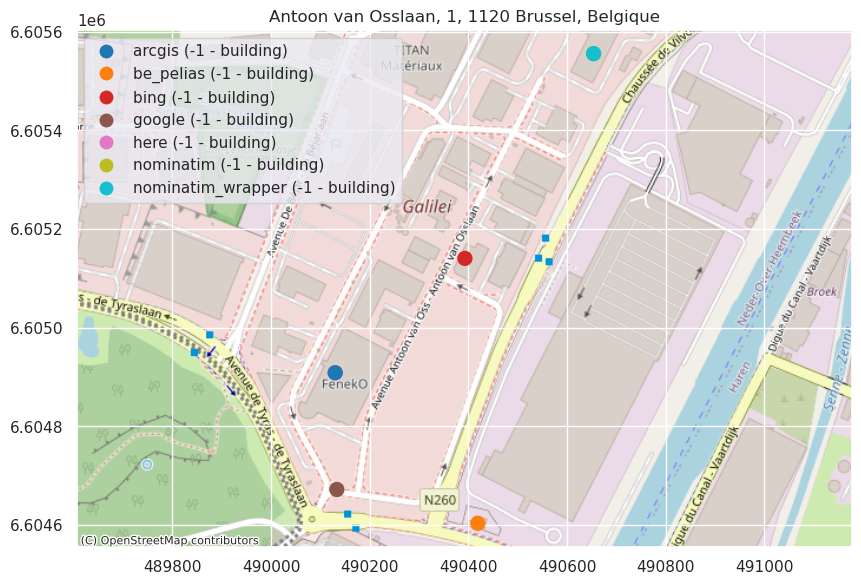

street housenumber postcode  city  \
614   Boulevard André Delvaux          15     7000  Mons   
1614  Boulevard André Delvaux          15     7000  Mons   
2614  Boulevard André Delvaux          15     7000  Mons   
3531  Boulevard André Delvaux          15     7000  Mons   
4473  Boulevard André Delvaux          15     7000  Mons   
5465  Boulevard André Delvaux          15     7000  Mons   
6463  Boulevard André Delvaux          15     7000  Mons   

                                               address  \
614   Boulevard André Delvaux, 15, 7000 Mons, Belgique   
1614  Boulevard André Delvaux, 15, 7000 Mons, Belgique   
2614  Boulevard André Delvaux, 15, 7000 Mons, Belgique   
3531  Boulevard André Delvaux, 15, 7000 Mons, Belgique   
4473  Boulevard André Delvaux, 15, 7000 Mons, Belgique   
5465  Boulevard André Delvaux, 15, 7000 Mons, Belgique   
6463  Boulevard André Delvaux, 15, 7000 Mons, Belgique   

                                               location           geocoder  \
614   (Boulevard André Delvaux 5, 7000 Mons, Belgiqu...               here   
1614  (Boulevard André Delvaux, Mons, Walloon Region...               bing   
2614  (Bd André Delvaux 15, 7000 Mons, Belgium, (50....             google   
3531  (Boulevard André Delvaux, Le Fort, Mons, Haina...          nominatim   
4473  (Boulevard André Delvaux, Le Fort, Mons, Haina...  nominatim_wrapper   
5465  (15, Boulevard André Delvaux, 7000 Mons, (50.4...          be_pelias   
6463  (Boulevard André Delvaux 15, 7000, Mons, (50.4...             arcgis   

      reference_key  duration precision                           point  \
614             614  0.076289  building  POINT (437674.842 6526362.635)   
1614            614  0.434857    street  POINT (437755.296 6526359.115)   
2614            614  0.103225  building  POINT (437272.533 6525579.255)   
3531            614  0.029844    street  POINT (438004.158 6526414.534)   
4473            614  0.038926    street  POINT (438004.158 6526414.534)   
5465            614  0.021832  building  POINT (437258.507 6525572.297)   
6463            614  0.121707  building  POINT (437849.515 6526435.374)   

      is_in_belgium                    median_point  nb_points  \
614            True  POINT (437473.688 6525970.945)        4.0   
1614           True  POINT (437473.688 6525970.945)        4.0   
2614           True  POINT (437473.688 6525970.945)        4.0   
3531           True  POINT (437473.688 6525970.945)        4.0   
4473           True  POINT (437473.688 6525970.945)        4.0   
5465           True  POINT (437473.688 6525970.945)        4.0   
6463           True  POINT (437473.688 6525970.945)        4.0   

      dist_to_median  nb_close_to_median  
614              NaN                 0.0  
1614             NaN                 0.0  
2614             NaN                 0.0  
3531             NaN                 0.0  
4473             NaN                 0.0  
5465             NaN                 0.0  
6463             NaN                 0.0

No median point


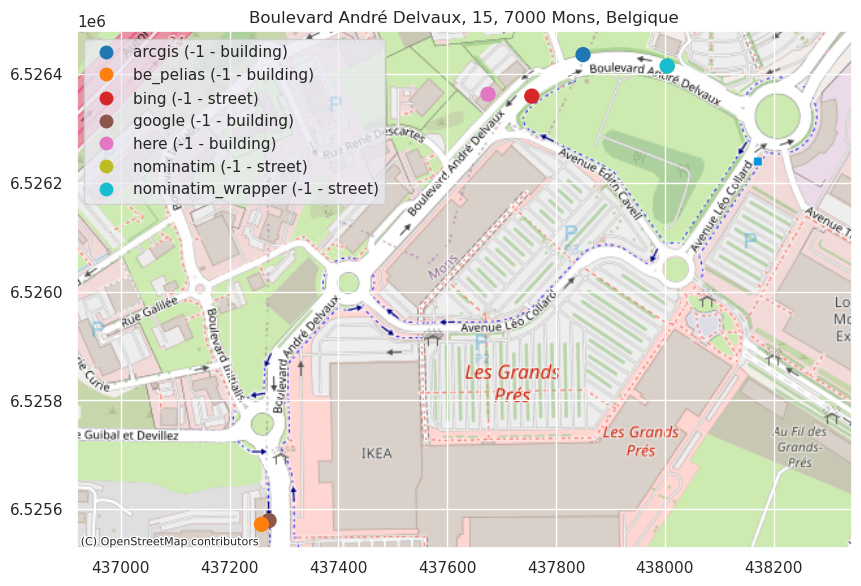

In [806]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:4].index:
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)

In [807]:
geocoded_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_all.pkl")

## Distance to median

### Average

geocoder
arcgis                 20.874729
be_pelias              40.118003
bing                   73.200716
google               1641.793030
here                   26.363788
nominatim             198.682166
nominatim_wrapper     411.529086
Name: dist_to_median, dtype: float64

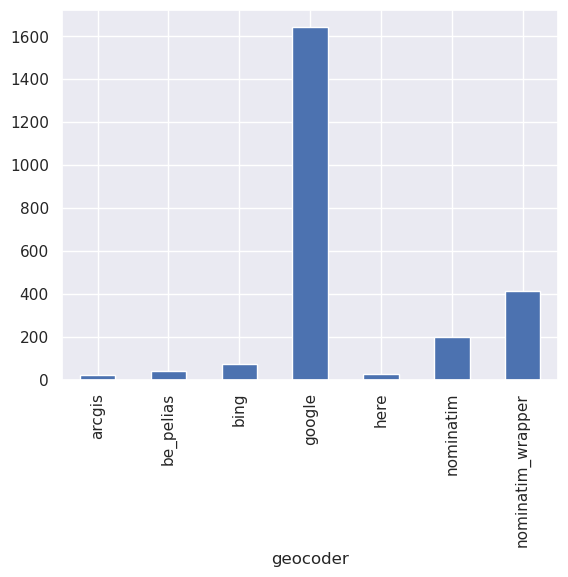

In [808]:
# d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

geocoder
arcgis                20.874729
be_pelias             40.118003
bing                  73.200716
google               290.673514
here                  26.363788
nominatim            198.682166
nominatim_wrapper    411.529086
Name: dist_to_median, dtype: float64

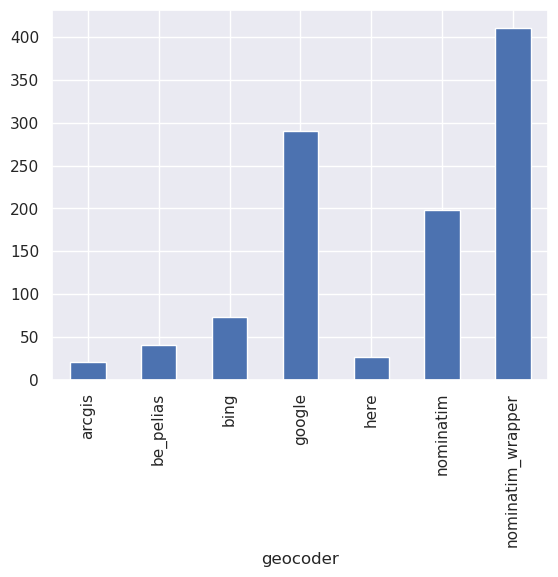

In [809]:
# skipping non reliable median

# d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

### Percentiles

In [810]:
#[geocoded_data.precision=="building"]#.drop_duplicates(subset="address")
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogLocator
def dist_to_median_line_plot(d, ax=None, title=None, legend=True):
    mean = d.groupby("geocoder").dist_to_median.mean().rename("Mean")

    perc_90 = d.groupby("geocoder").dist_to_median.quantile(0.90).rename("Perc 90%")
    perc_95 = d.groupby("geocoder").dist_to_median.quantile(0.95).rename("Perc 95%")
    perc_99 = d.groupby("geocoder").dist_to_median.quantile(0.99).rename("Perc 99%")
    perc_50 = d.groupby("geocoder").dist_to_median.quantile(0.50).rename("Median")
    maxd = d.groupby("geocoder").dist_to_median.max().rename("Max")
    tops = [ d.groupby("geocoder").dist_to_median.nlargest(i).reset_index().groupby("geocoder").dist_to_median.min() for i in range(2, 50)]#.drop_index(level=1)#@@.tail(1)#.unstack()
#     mean    = mean.sort_values()
#     perc_90 = perc_90.reindex_like(mean)
#     perc_99 = perc_99.reindex_like(mean)
#     perc_50 = perc_50.reindex_like(mean)
#     maxd =    maxd.reindex_like(mean)

    mean    = mean.reindex(coders)
#     perc_90 = perc_90.reindex(coders)
    perc_95 = perc_95.reindex(coders)
    perc_50 = perc_50.reindex(coders)
    maxd =    maxd.reindex(coders)
    tops =    [t.reindex(coders) for t in tops]

    display(mean)
    ax = mean.plot(legend=legend, linestyle='dotted',marker='s', ax=ax, title=title, figsize=def_figsize)
    ax = perc_50.plot(ax=ax, legend=legend,linestyle='dotted', marker='<')
    # ax = perc_90.rename("Perc 90%").plot(ax=ax, legend=True, linestyle='dotted', marker='o')
    ax = perc_95.plot(ax=ax, legend=legend, linestyle='dotted', marker='P')
    # ax = perc_99.rename("Perc 99%").plot(ax=ax, legend=True, linestyle='dotted', marker='P')
    ax = maxd.plot(ax=ax, rot=90, legend=legend, linestyle='dotted',marker='^', logy=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    for t in tops:
        t.plot(ax=ax, rot=90, legend=False, linestyle="", marker='.', logy=True, c='C3', zorder=1, alpha=0.2)
    ax.set_ylabel(f"Distance to median point ({dataset})")
#     ax.set_yscale("log")
#     ax.spines['left'].set_color('red')
#     plt.tick_params(axis='y', which='minor')
#     ax.tick_params(axis='y', colors='red')
#     ax.minorticks_on()
    ax.tick_params(axis="both", direction="out", which="both", left=True, top=False)
#     ax.yaxis.set_minor_locator(LogLocator(5))
#     ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax.set_xlabel(None)
    display(pd.DataFrame([mean, perc_50, perc_95, maxd]))
    


geocoder
here                   26.363788
bing                   73.200716
google               1641.793030
nominatim             198.682166
nominatim_wrapper     411.529086
be_pelias              40.118003
arcgis                 20.874729
Name: Mean, dtype: float64

geocoder         here         bing        google    nominatim  \
Mean        26.363788    73.200716  1.641793e+03   198.682166   
Median       0.624923     0.734616  1.507893e+01     4.809164   
Perc 95%    65.803882   184.057787  6.034794e+02  1225.967581   
Max       3204.406893  6351.148401  1.323037e+06  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             411.529086    40.118003    20.874729  
Median             5.357598     0.621836     0.445356  
Perc 95%        1518.302600    85.098559    32.407179  
Max           101244.102275  5990.979679  4485.280960

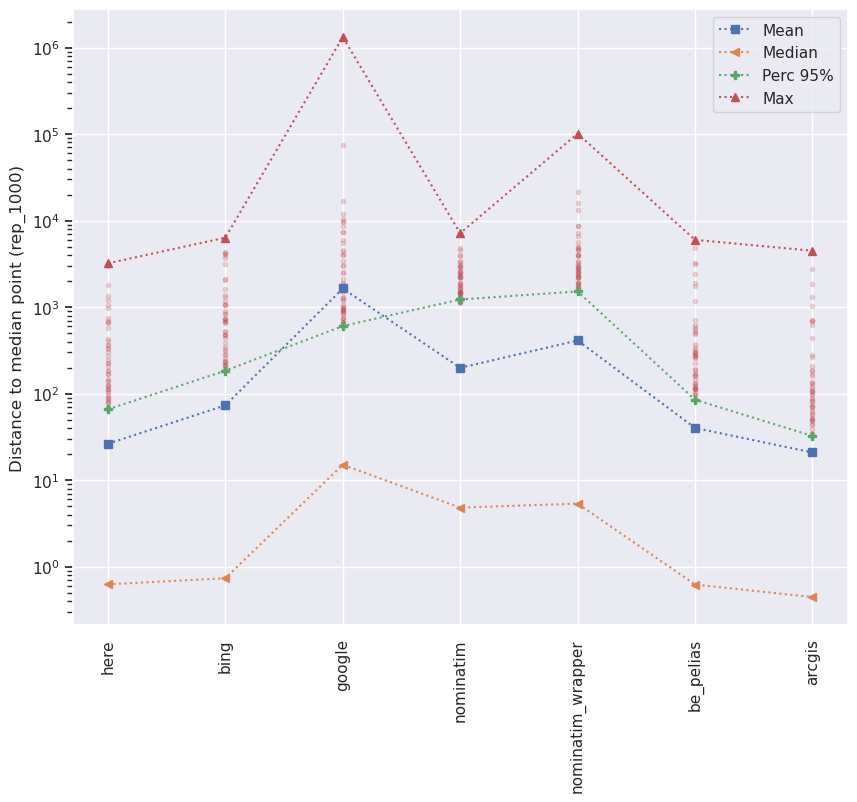

In [811]:
dist_to_median_line_plot(geocoded_data)

pdf_savefig()


geocoder
here                   26.363788
bing                   73.200716
google               1641.793030
nominatim             198.682166
nominatim_wrapper     411.529086
be_pelias              40.118003
arcgis                 20.874729
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here         bing        google    nominatim  \
Mean        26.363788    73.200716  1.641793e+03   198.682166   
Median       0.624923     0.734616  1.507893e+01     4.809164   
Perc 95%    65.803882   184.057787  6.034794e+02  1225.967581   
Max       3204.406893  6351.148401  1.323037e+06  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             411.529086    40.118003    20.874729  
Median             5.357598     0.621836     0.445356  
Perc 95%        1518.302600    85.098559    32.407179  
Max           101244.102275  5990.979679  4485.280960

geocoder
here                  26.091730
bing                  62.644708
google               169.373203
nominatim            201.104145
nominatim_wrapper    263.376767
be_pelias             40.118003
arcgis                20.723888
Name: Mean, dtype: float64

geocoder         here         bing        google    nominatim  \
Mean        26.091730    62.644708    169.373203   201.104145   
Median       0.618124     0.738298     15.003432     4.818703   
Perc 95%    59.721759   177.679457    523.027493  1275.501502   
Max       3204.406893  5997.964409  10526.816283  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             263.376767    40.118003    20.723888  
Median             5.327168     0.621836     0.444725  
Perc 95%        1477.739684    85.098559    31.778038  
Max            13437.503477  5990.979679  4485.280960

geocoder
arcgis               0.999000
be_pelias            1.000000
bing                 0.942000
google               0.972000
here                 0.991000
nominatim            0.983778
nominatim_wrapper    0.977867
Name: reference_key, dtype: float64

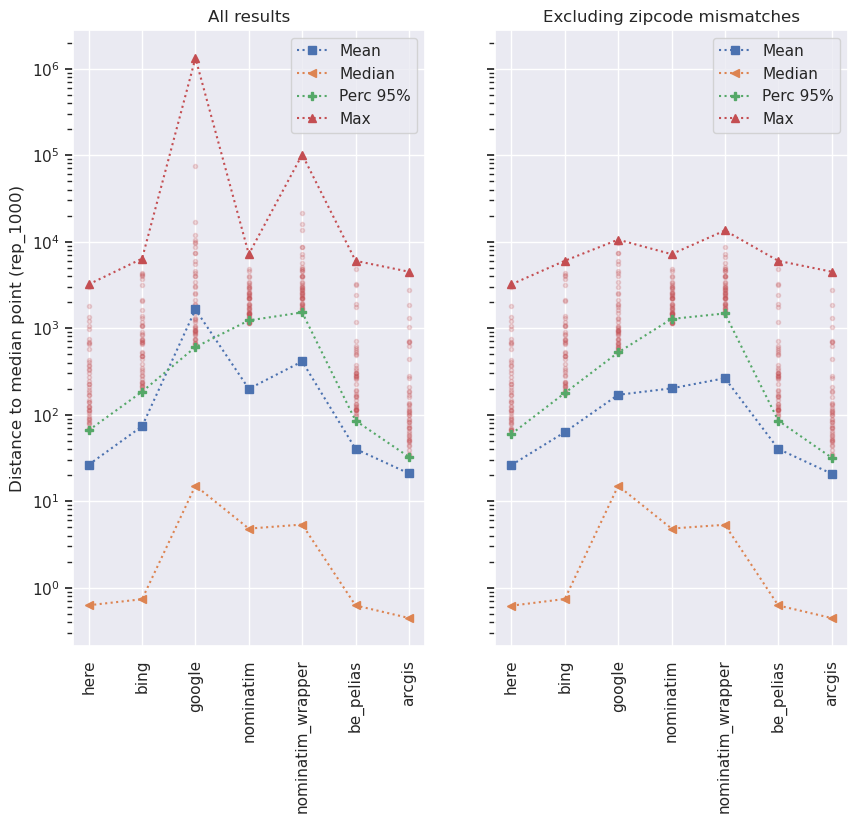

In [812]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

geocoder
here                   26.363788
bing                   73.200716
google               1641.793030
nominatim             198.682166
nominatim_wrapper     411.529086
be_pelias              40.118003
arcgis                 20.874729
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here         bing        google    nominatim  \
Mean        26.363788    73.200716  1.641793e+03   198.682166   
Median       0.624923     0.734616  1.507893e+01     4.809164   
Perc 95%    65.803882   184.057787  6.034794e+02  1225.967581   
Max       3204.406893  6351.148401  1.323037e+06  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             411.529086    40.118003    20.874729  
Median             5.357598     0.621836     0.445356  
Perc 95%        1518.302600    85.098559    32.407179  
Max           101244.102275  5990.979679  4485.280960

geocoder
here                  26.363788
bing                  73.200716
google               290.673514
nominatim            198.682166
nominatim_wrapper    411.529086
be_pelias             40.118003
arcgis                20.874729
Name: Mean, dtype: float64

geocoder         here         bing        google    nominatim  \
Mean        26.363788    73.200716    290.673514   198.682166   
Median       0.624923     0.734616     15.064174     4.809164   
Perc 95%    65.803882   184.057787    599.519850  1225.967581   
Max       3204.406893  6351.148401  75533.459499  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             411.529086    40.118003    20.874729  
Median             5.357598     0.621836     0.445356  
Perc 95%        1518.302600    85.098559    32.407179  
Max           101244.102275  5990.979679  4485.280960

geocoder
arcgis               1.000
be_pelias            1.000
bing                 1.000
google               0.999
here                 1.000
nominatim            1.000
nominatim_wrapper    1.000
Name: reference_key, dtype: float64

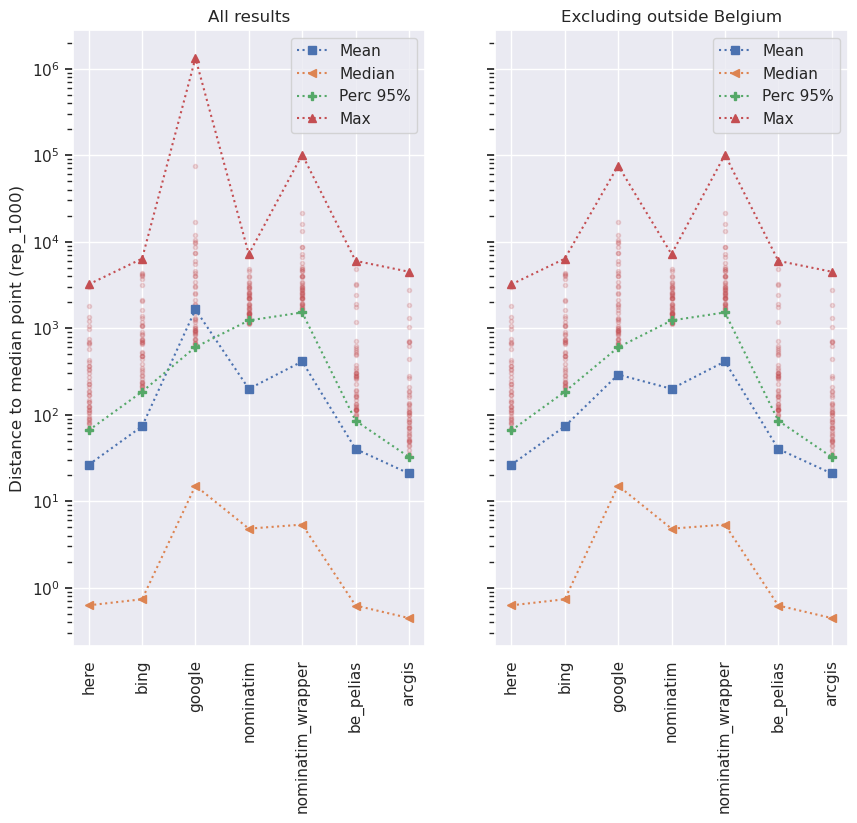

In [813]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.is_in_belgium]

dist_to_median_line_plot(d, ax[1], "Excluding outside Belgium", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

geocoder
here                   26.363788
bing                   73.200716
google               1641.793030
nominatim             198.682166
nominatim_wrapper     411.529086
be_pelias              40.118003
arcgis                 20.874729
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here         bing        google    nominatim  \
Mean        26.363788    73.200716  1.641793e+03   198.682166   
Median       0.624923     0.734616  1.507893e+01     4.809164   
Perc 95%    65.803882   184.057787  6.034794e+02  1225.967581   
Max       3204.406893  6351.148401  1.323037e+06  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             411.529086    40.118003    20.874729  
Median             5.357598     0.621836     0.445356  
Perc 95%        1518.302600    85.098559    32.407179  
Max           101244.102275  5990.979679  4485.280960

geocoder
here                  26.363788
bing                  60.247699
google               242.407625
nominatim            198.682166
nominatim_wrapper    404.252206
be_pelias             23.289491
arcgis                18.093175
Name: Mean, dtype: float64

geocoder         here         bing        google    nominatim  \
Mean        26.363788    60.247699    242.407625   198.682166   
Median       0.624923     0.731388     14.646822     4.809164   
Perc 95%    65.803882   173.112533    477.966264  1225.967581   
Max       3204.406893  6351.148401  75533.459499  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             404.252206    23.289491    18.093175  
Median             5.329903     0.618440     0.444725  
Perc 95%        1494.241248    74.753819    31.778038  
Max           101244.102275  3151.770608  4485.280960

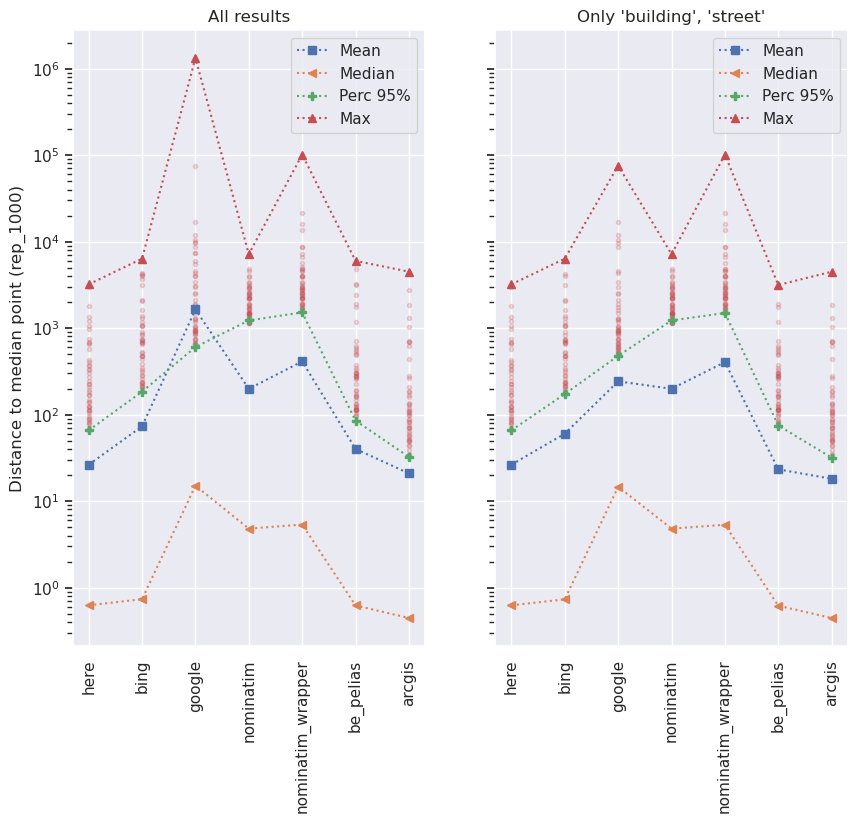

In [814]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street'])]

dist_to_median_line_plot(d, ax[1], "Only 'building', 'street'")

pdf_savefig()


geocoder
here                   26.363788
bing                   73.200716
google               1641.793030
nominatim             198.682166
nominatim_wrapper     411.529086
be_pelias              40.118003
arcgis                 20.874729
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here         bing        google    nominatim  \
Mean        26.363788    73.200716  1.641793e+03   198.682166   
Median       0.624923     0.734616  1.507893e+01     4.809164   
Perc 95%    65.803882   184.057787  6.034794e+02  1225.967581   
Max       3204.406893  6351.148401  1.323037e+06  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             411.529086    40.118003    20.874729  
Median             5.357598     0.621836     0.445356  
Perc 95%        1518.302600    85.098559    32.407179  
Max           101244.102275  5990.979679  4485.280960

geocoder
here                  26.091730
bing                  48.901308
google               125.885354
nominatim            201.104145
nominatim_wrapper    255.627627
be_pelias             23.289491
arcgis                17.939332
Name: Mean, dtype: float64

geocoder         here         bing        google    nominatim  \
Mean        26.091730    48.901308    125.885354   201.104145   
Median       0.618124     0.734095     14.654047     4.818703   
Perc 95%    59.721759   160.058472    462.642498  1275.501502   
Max       3204.406893  5997.964409  10526.816283  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             255.627627    23.289491    17.939332  
Median             5.312464     0.618440     0.444094  
Perc 95%        1463.483227    74.753819    31.538283  
Max            13437.503477  3151.770608  4485.280960

geocoder
arcgis               0.998000
be_pelias            0.994960
bing                 0.938000
google               0.964000
here                 0.991000
nominatim            0.983778
nominatim_wrapper    0.975855
Name: reference_key, dtype: float64

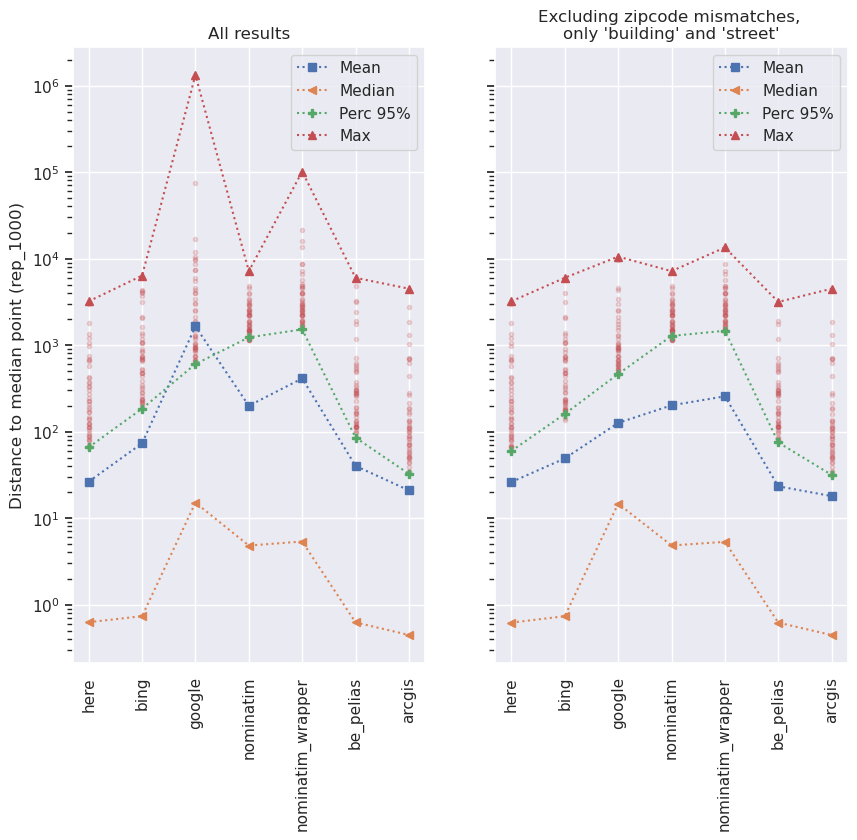

In [815]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street']) & geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches, \nonly 'building' and 'street'", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

geocoder
here                   26.363788
bing                   73.200716
google               1641.793030
nominatim             198.682166
nominatim_wrapper     411.529086
be_pelias              40.118003
arcgis                 20.874729
Name: Mean, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


geocoder         here         bing        google    nominatim  \
Mean        26.363788    73.200716  1.641793e+03   198.682166   
Median       0.624923     0.734616  1.507893e+01     4.809164   
Perc 95%    65.803882   184.057787  6.034794e+02  1225.967581   
Max       3204.406893  6351.148401  1.323037e+06  7155.643163   

geocoder  nominatim_wrapper    be_pelias       arcgis  
Mean             411.529086    40.118003    20.874729  
Median             5.357598     0.621836     0.445356  
Perc 95%        1518.302600    85.098559    32.407179  
Max           101244.102275  5990.979679  4485.280960

geocoder
here                NaN
bing                NaN
google              NaN
nominatim           NaN
nominatim_wrapper   NaN
be_pelias           NaN
arcgis              NaN
Name: Mean, dtype: float64

geocoder  here  bing  google  nominatim  nominatim_wrapper  be_pelias  arcgis
Mean       NaN   NaN     NaN        NaN                NaN        NaN     NaN
Median     NaN   NaN     NaN        NaN                NaN        NaN     NaN
Perc 95%   NaN   NaN     NaN        NaN                NaN        NaN     NaN
Max        NaN   NaN     NaN        NaN                NaN        NaN     NaN

geocoder
arcgis              NaN
be_pelias           NaN
bing                NaN
google              NaN
here                NaN
nominatim           NaN
nominatim_wrapper   NaN
Name: reference_key, dtype: float64

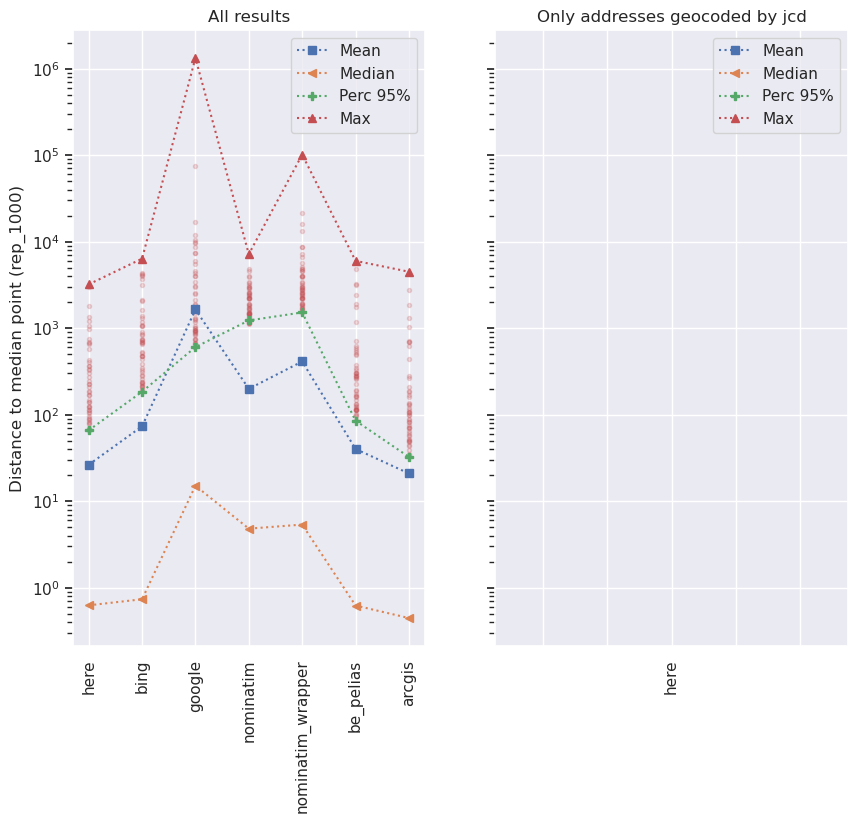

In [816]:
f, ax=plt.subplots(1,2, figsize=(16,8), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.reference_key.isin(geocoded_data[geocoded_data.geocoder=="jcd"].reference_key)]

dist_to_median_line_plot(d, ax[1], "Only addresses geocoded by jcd", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

# Geocoder outsiders

In [817]:
gcd="jcd"

In [818]:
x = geocoded_data[geocoded_data.geocoder==gcd].sort_values("dist_to_median")
x

Empty GeoDataFrame
Columns: [street, housenumber, postcode, city, address, location, geocoder, reference_key, duration, precision, point, is_in_belgium, median_point, nb_points, dist_to_median, nb_close_to_median]
Index: []

In [819]:
for addr in x.iloc[-10:].address:
    
    plot_address(geocoded_data, addr)

In [820]:

# plot_address(geocoded_data, geocoded_data.loc[7930].address)

In [821]:
pdf.close()

# Tests

In [822]:
geocoded_data[geocoded_data.geocoder=="ngi_pelias"].precision.value_counts()

Series([], Name: count, dtype: int64)

In [823]:
# geocoded_data[(geocoded_data.geocoder=="ngi_pelias") & (geocoded_data.precision != "building")].sort_values(["precision", "postcode"]).iloc[0:60]

In [824]:
geocoders["pelias"].geocode({'address': f'A VIBON DJU(DU VIEUX BON DIEU',
   'postalcode': '4350',
   'locality': 'remicourt'}).raw
#     print res["properties"][""]

GeocoderUnavailable: HTTPConnectionPool(host='172.27.0.64', port=4005): Max retries exceeded with url: /v1/search/structured?address=A+VIBON+DJU%28DU+VIEUX+BON+DIEU&postalcode=4350&locality=remicourt (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7febab4e4050>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
geocoders["be_pelias"].geocode({'street': f'Rue Marconi',
                                 'housenumber':'113',
   'postcode': '1190',
   'city': 'forest'}).raw
#     print res["properties"][""]

In [ ]:
# geocoders["pelias"].geocode("Rue Auguste Heen, 17, 1190").raw

In [ ]:
# geocoded_data[geocoded_data.geocoder=="ngi_pelias"].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

In [ ]:
# geocoded_data[(geocoded_data.geocoder=="ngi_pelias") & (geocoded_data.precision=="street")].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

In [ ]:
pelias_res = geocoded_data[(geocoded_data.geocoder=="ngi_pelias")]

pelias_res[pelias_res.precision!="building"].sort_values(["precision", "postcode"])#.iloc[0:60]

In [ ]:
# pelias_res.loc[291].location.raw

In [ ]:
pelias_res[pelias_res.location.apply(lambda rec: rec.raw["properties"]["match_type"]== "fallback" and rec.raw["properties"]["accuracy"]== "point") ]

In [ ]:
pelias_res[pelias_res.location.apply(lambda rec: rec.raw["properties"]["accuracy"]== "point") & (pelias_res.precision!="building") ]

In [ ]:
pelias_res.loc[52].location.raw

In [ ]:
data#set

In [ ]:
k = 432

d =data.loc[k]
display(d)
d = d.str.replace("(L.L)", "", regex=False)
display(d)

r = geocoders["ngi_pelias"].geocode(d.to_dict(), exactly_one=False)#[0].raw

r

In [ ]:
r[0].raw

In [ ]:
data.loc[k]

In [ ]:
geocoded_data.location.iloc[1].raw["properties"]

In [ ]:
geocoded_data["pelias_street"] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["street"] if rec and "properties" in rec.raw and "street" in rec.raw["properties"] else pd.NA)
geocoded_data["pelias_postalcode"] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["postalcode"] if rec and "properties" in rec.raw and "postalcode" in rec.raw["properties"] else pd.NA)

for f in 'municipality_name_fr', 'municipality_name_nl', 'municipality_name_de',  'postname_fr', 'postname_nl',  'postname_fr':
    geocoded_data["pelias_"+f] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["addendum"]["best"][f] if rec and "addendum" in rec.raw["properties"] and "best" in rec.raw["properties"]["addendum"] and f in rec.raw["properties"]["addendum"]["best"] else pd.NA)
    

In [ ]:
geocoded_data.drop(["reference_key", "address", "location", "geocoder", "duration", "is_in_belgium", "median_point", "nb_points", "dist_to_median", "nb_close_to_median"], axis=1, errors="ignore").to_csv("output/pelias_rep.csv")

In [ ]:
# geocoded_data[geocoded_data.pelias_postname_fr.notnull()]
dataset